In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import find_peaks
import sys
from scipy.fft import rfft, rfftfreq
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
video = cv2.VideoCapture('/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject13/vid.avi')

fps = video.get(cv2.CAP_PROP_FPS)

print('FPS:', fps)

video.release()

FPS: 29.7903


In [6]:
npz_file_path = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz'

data = np.load(npz_file_path)
print(data['video'].shape)
print(data['wave'].shape)
print(data['hr'].shape)

(1547, 64, 64, 3)
(1547,)
(1547,)


rPPG based Average Heart Rate (BPM):  107.19847196870926
Actual Average Heart Rate:  106.70456819650937


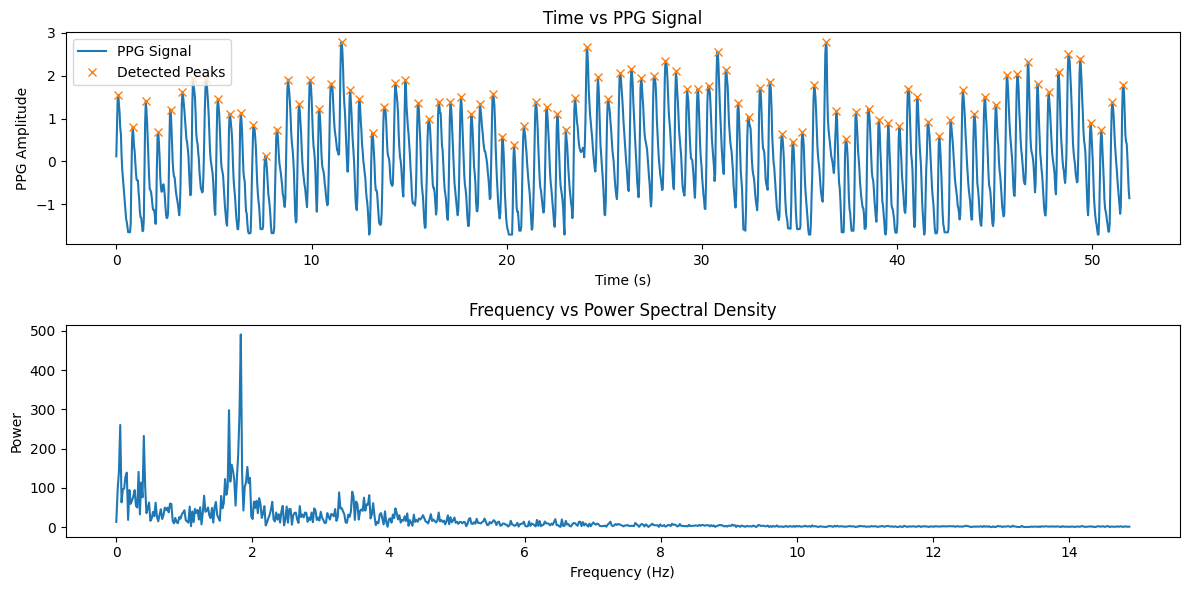

In [7]:
PPG_Signal = data['wave']
time = np.arange(PPG_Signal.size) / fps  # 30FPS로 촬영된 데이터, 시간 배열 생성

# FFT를 사용해 신호의 주파수 도메인 변환
psd = np.abs(rfft(PPG_Signal))
freqs = rfftfreq(PPG_Signal.size, 1 / fps)  # 샘플링 레이트는 초당 30프레임

# 신호에서 피크 찾기
peak_indices, _ = find_peaks(PPG_Signal, distance=10)  # 적절한 거리 설정
IBI = np.diff(peak_indices) / fps  # IBI 계산, 초 단위로 변환

# 모든 IBI 값의 평균을 계산
average_IBI = np.mean(IBI)
bpm_avg = 60 / average_IBI  # 분당 박동수 계산

print("rPPG based Average Heart Rate (BPM): ", bpm_avg)
print("Actual Average Heart Rate: ", np.mean(data['hr']))

# 플로팅
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, PPG_Signal, label='PPG Signal')
plt.plot(time[peak_indices], PPG_Signal[peak_indices], "x", label='Detected Peaks')
plt.title('Time vs PPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('PPG Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freqs, psd)
plt.title('Frequency vs Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

In [23]:
# 미분을 계산하기 위한 함수 정의
def derivative(signal):
    # 중앙 차분을 사용하여 미분 계산
    return np.gradient(signal)

In [34]:
# 이 함수는 npz 파일에서 비디오 데이터를 로드하고, 그린 채널의 변화량을 계산하여 신호로 변환하는 데 사용됩니다.
def extract_green_channel_signal(npz_data):
    video_data = npz_data['video']  # (frame_number, height, width, channels)
    green_channel = video_data[:, :, :, 1]  # 그린 채널 추출

    # 각 프레임에 대한 그린 채널의 평균값 계산
    green_channel_mean = green_channel.mean(axis=(1, 2))
    smoothed_wave = gaussian_filter(green_channel_mean, sigma=2)
    diff_smoothed_wave = derivative(smoothed_wave)

    return diff_smoothed_wave

In [30]:
def calculate_hr(npz_data, fps=fps, window_size=150, step_size=30):
    """심박수 계산 및 시간 배열 반환"""
    PPG_Signal = extract_green_channel_signal(npz_data)
    hr_real = npz_data['hr']  # 실제 심박수 데이터
    bpm_per_frame = []
    times = []

    for start in range(0, len(PPG_Signal) - window_size, step_size):
        end = start + window_size
        segment = PPG_Signal[start:end]
        peaks, _ = find_peaks(segment, distance=10)

        if len(peaks) > 1:
            ibi = np.diff(peaks) / fps
            bpm = 60 / np.mean(ibi) if len(ibi) > 0 else np.nan
        else:
            bpm = np.nan

        bpm_per_frame.append(bpm)
        times.append((start + end) / 2 / fps)

     # hr_real을 times에 맞춰서 조정
    hr_real_adjusted = [hr_real[int(time * fps)] for time in times if int(time * fps) < len(hr_real)]

    return times, bpm_per_frame, hr_real_adjusted

def plot_hr(times, bpm_per_frame, hr_real):
    """심박수 데이터 플롯 및 평균 값 출력"""
    # hr_real에서 10 이하인 값을 NaN으로 설정
    hr_real_filtered = np.array(hr_real)
    hr_real_filtered[hr_real_filtered <= 10] = np.nan

    plt.figure(figsize=(20, 5))
    plt.plot(times, bpm_per_frame, label='Estimated Heart Rate', color='blue', alpha=0.6)
    # plt.plot(np.arange(len(hr_real_filtered)) / fps, hr_real_filtered, label='Actual Heart Rate', color='red', alpha=0.6)
    plt.plot(times, hr_real_filtered, label='Actual Heart Rate', color='red', alpha=0.6)
    plt.title('Estimated vs Actual Heart Rate Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Heart Rate (BPM)')
    plt.legend()
    plt.show()

    # 계산된 BPM과 실제 HR의 평균 계산
    # NaN 값을 무시하고 평균 계산
    # 계산된 BPM과 실제 HR의 평균 및 오류 메트릭 계산
    mean_estimated_bpm = np.nanmean(bpm_per_frame)
    mean_actual_hr = np.nanmean(hr_real_filtered)
    # mse = mean_squared_error([mean_actual_hr], [mean_estimated_bpm])
    # rmse = np.sqrt(mse)
    # mae = mean_absolute_error([mean_actual_hr], [mean_estimated_bpm])
    mae, rmse = calculate_errors(bpm_per_frame, hr_real_filtered)

    # 결과 출력
    print(f"Average Estimated Heart Rate: {mean_estimated_bpm:.2f}")
    print(f"Average Actual Heart Rate: {mean_actual_hr:.2f}")
    print(f"MAE: {mae:.2f}")
    # print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print("---------------------------------------------------------------------------")

    return rmse, mae

def calculate_errors(bpm_per_frame, hr_real_filtered):
    # NaN이 아닌 인덱스를 찾습니다.
    valid_indices = ~np.isnan(bpm_per_frame) & ~np.isnan(hr_real_filtered)

    # 유효한 인덱스만 사용하여 데이터를 필터링합니다.
    filtered_bpm = np.array(bpm_per_frame)[valid_indices]
    filtered_hr_real = np.array(hr_real_filtered)[valid_indices]

    # MAE와 RMSE를 계산합니다.
    mae = mean_absolute_error(filtered_hr_real, filtered_bpm)
    rmse = np.sqrt(mean_squared_error(filtered_hr_real, filtered_bpm))

    return mae, rmse

def process_npz_files(directory):
    """디렉토리 내의 모든 NPZ 파일 처리"""
    mse_list, rmse_list, mae_list = [], [], []
    subject_list = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.npz'):
            file_path = os.path.join(directory, file_name)
            print(f"Processing {file_path}...")
            npz_data = np.load(file_path)
            times, bpm_per_frame, hr_real = calculate_hr(npz_data)
            rmse, mae = plot_hr(times, bpm_per_frame, hr_real)
            # mse_list.append(mse)
            rmse_list.append(rmse)
            mae_list.append(mae)
            subject_list.append(file_name.replace('.npz', ''))

    return rmse_list, mae_list, subject_list

Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz...


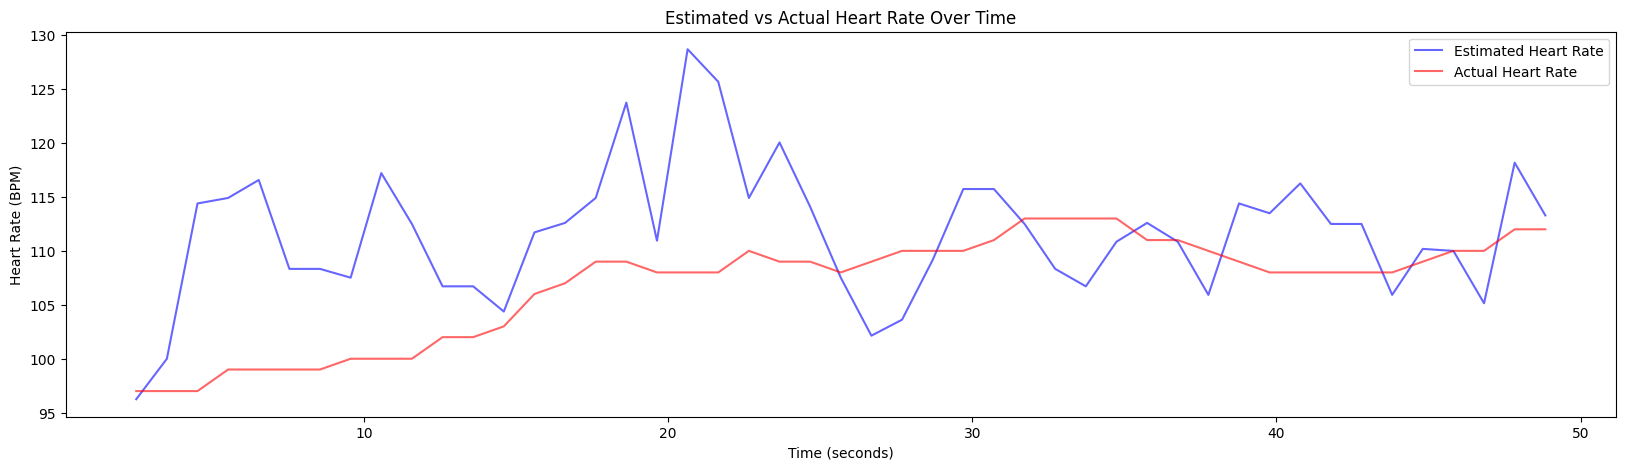

Average Estimated Heart Rate: 111.59
Average Actual Heart Rate: 106.83
MAE: 6.46
RMSE: 8.39
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject10.npz...


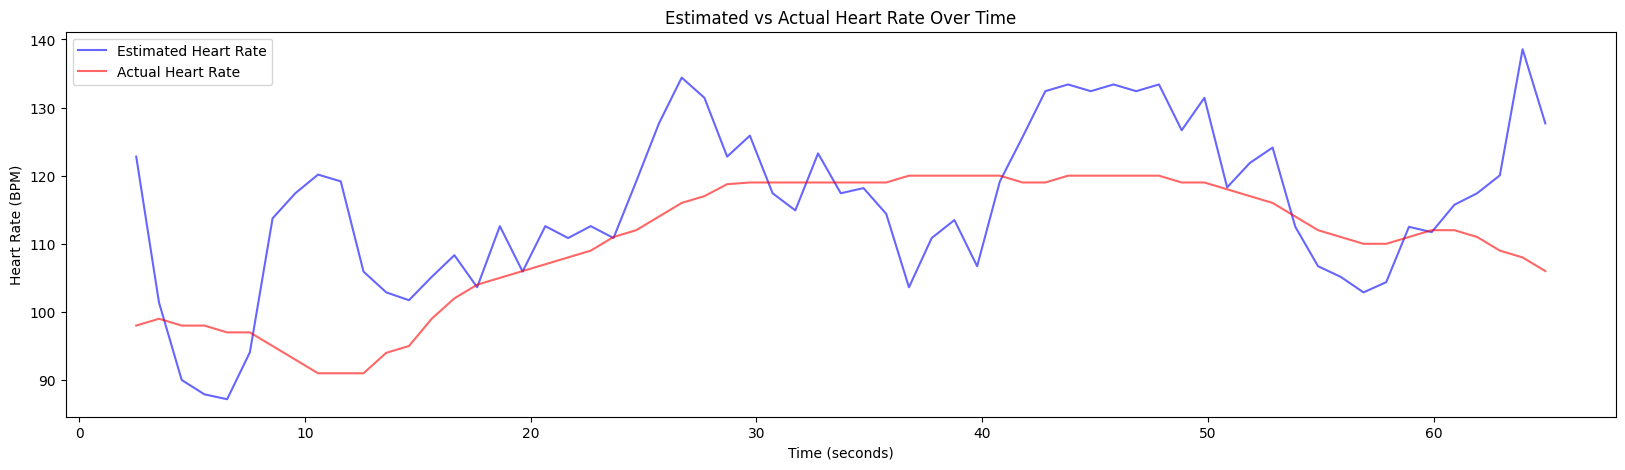

Average Estimated Heart Rate: 115.69
Average Actual Heart Rate: 110.35
MAE: 9.02
RMSE: 11.68
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject11.npz...


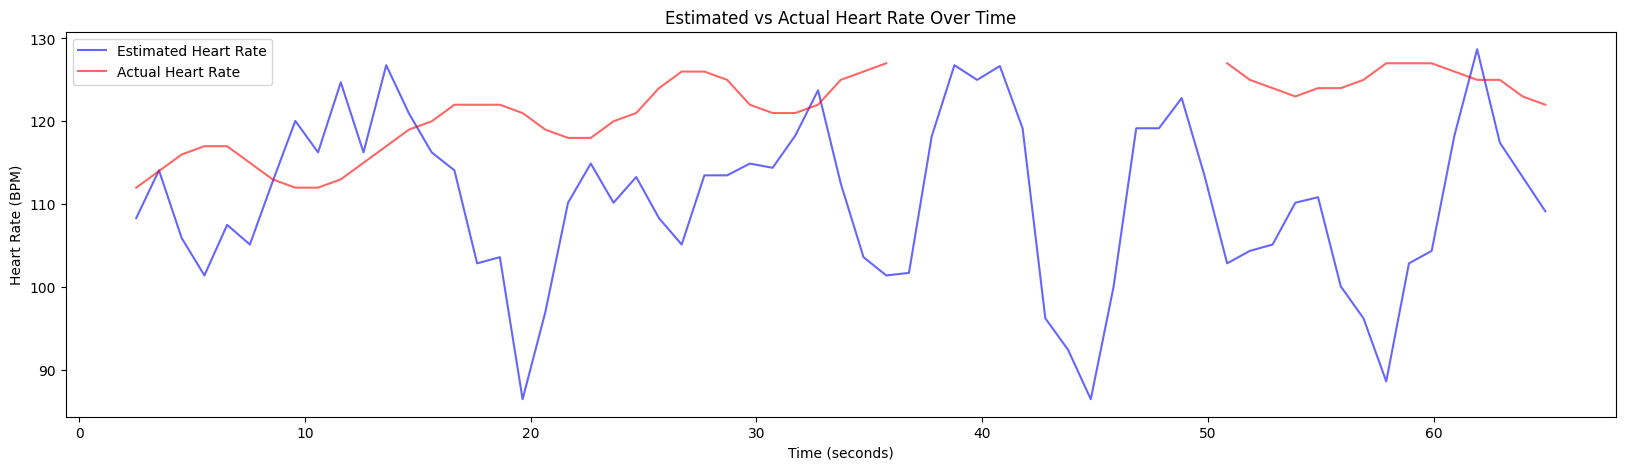

Average Estimated Heart Rate: 110.45
Average Actual Heart Rate: 121.10
MAE: 12.82
RMSE: 15.64
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject12.npz...


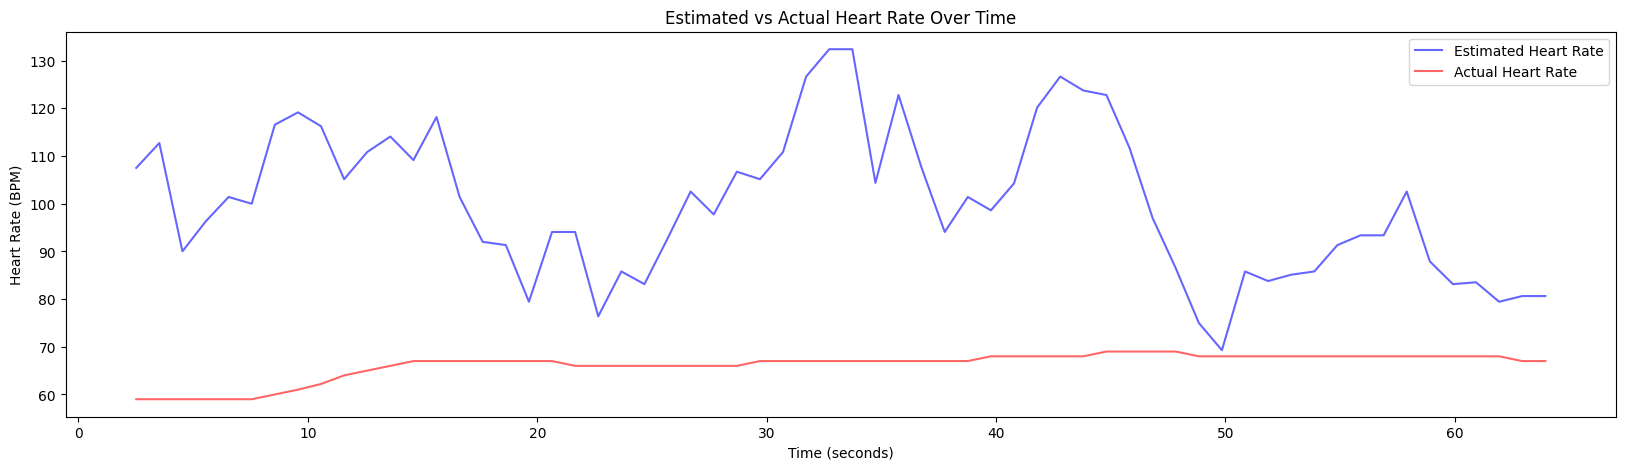

Average Estimated Heart Rate: 100.07
Average Actual Heart Rate: 66.15
MAE: 33.92
RMSE: 37.50
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject13.npz...


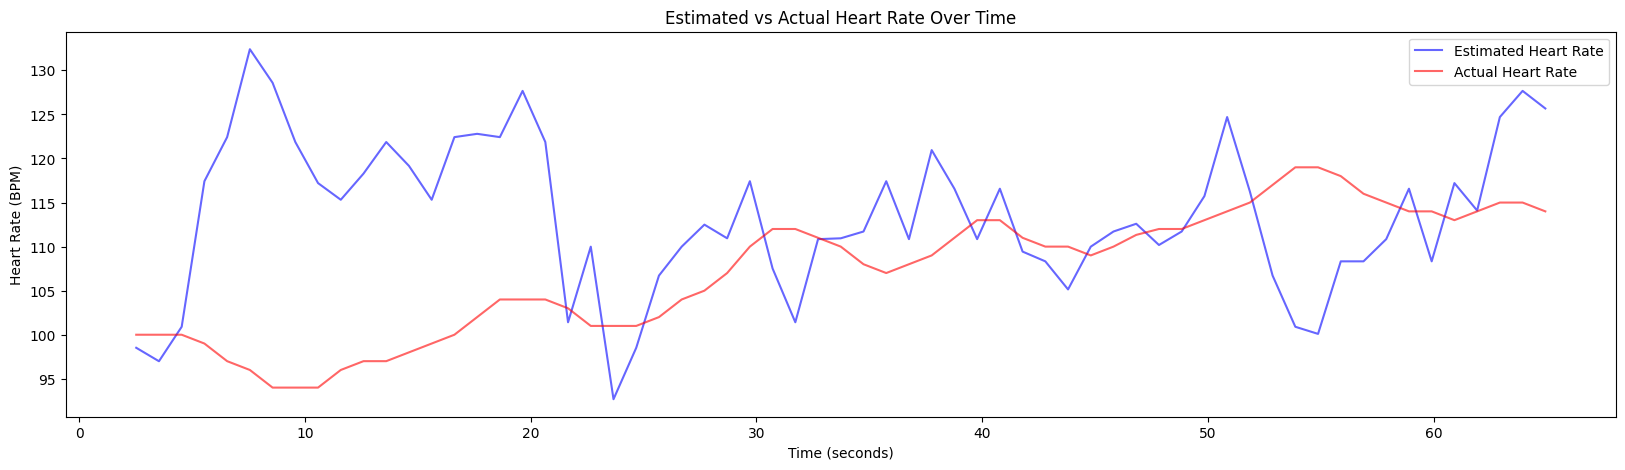

Average Estimated Heart Rate: 113.41
Average Actual Heart Rate: 107.20
MAE: 9.98
RMSE: 13.52
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject14.npz...


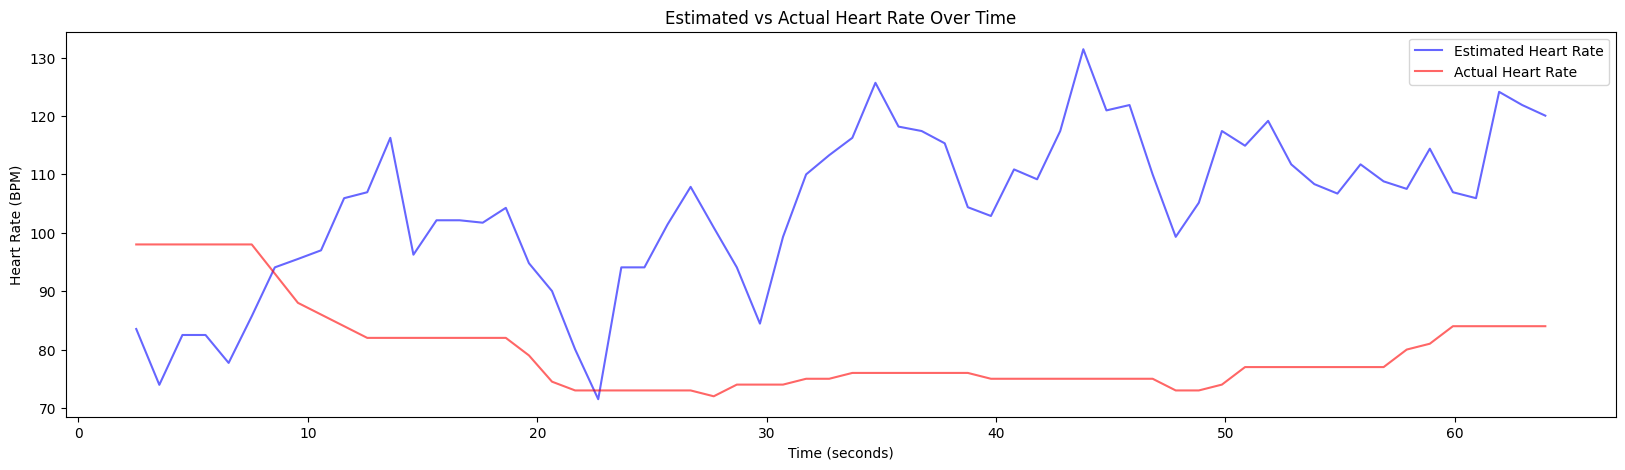

Average Estimated Heart Rate: 104.35
Average Actual Heart Rate: 79.75
MAE: 27.94
RMSE: 30.41
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject15.npz...


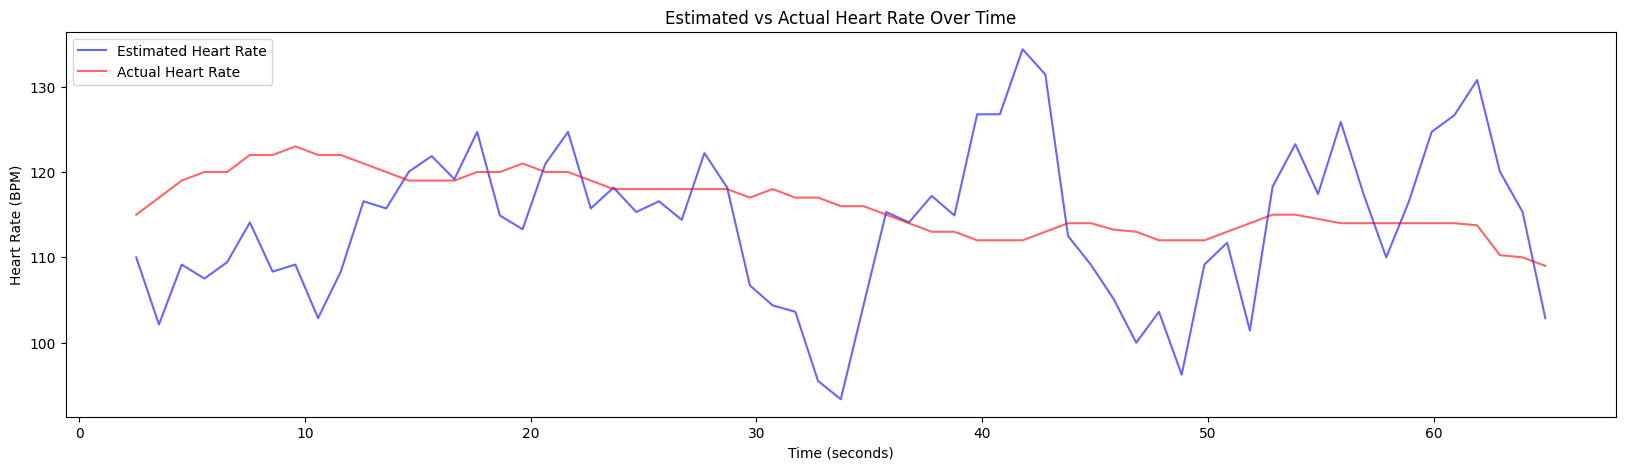

Average Estimated Heart Rate: 113.98
Average Actual Heart Rate: 116.22
MAE: 8.07
RMSE: 10.12
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject16.npz...


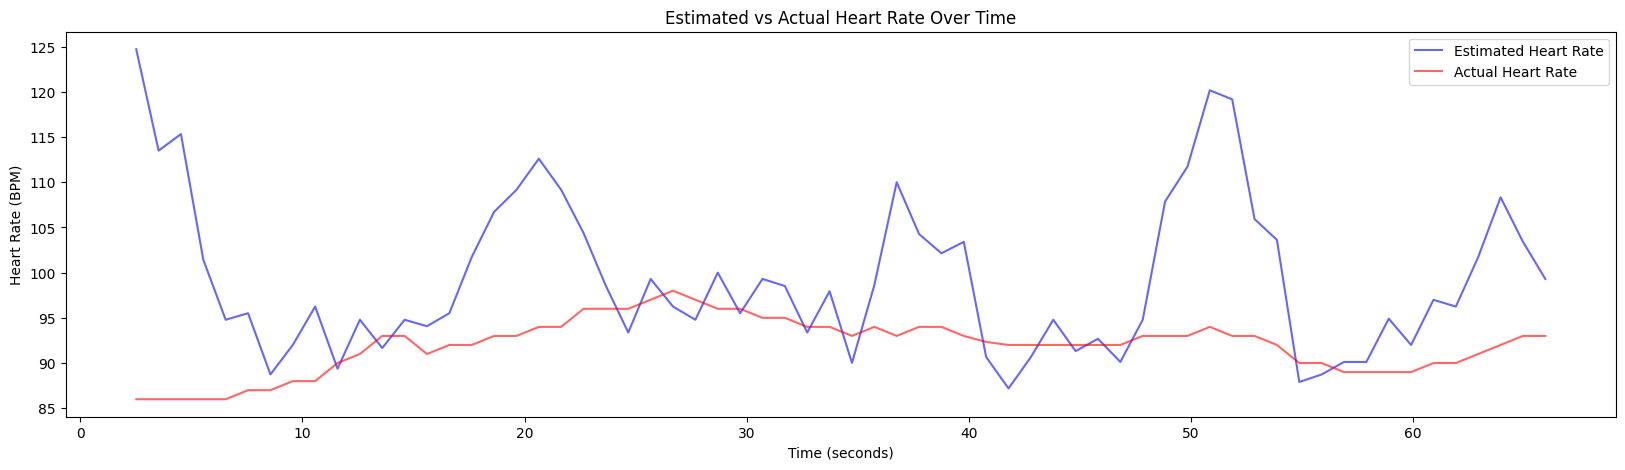

Average Estimated Heart Rate: 99.25
Average Actual Heart Rate: 91.99
MAE: 8.08
RMSE: 11.50
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject17.npz...


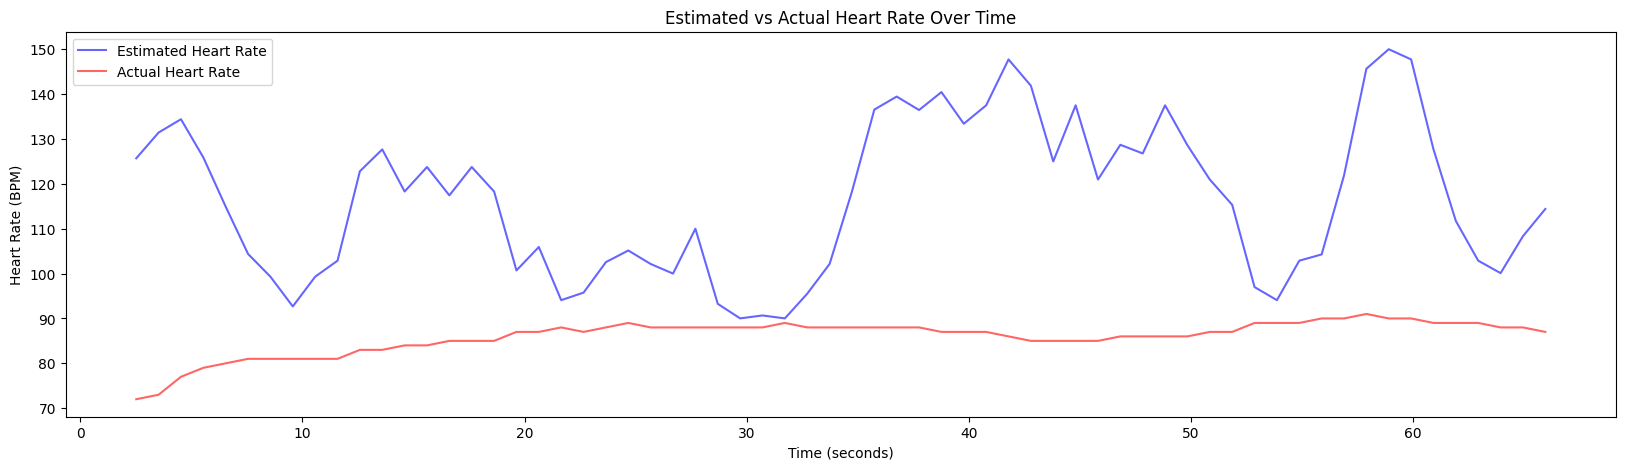

Average Estimated Heart Rate: 116.59
Average Actual Heart Rate: 85.92
MAE: 30.67
RMSE: 35.45
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject18.npz...


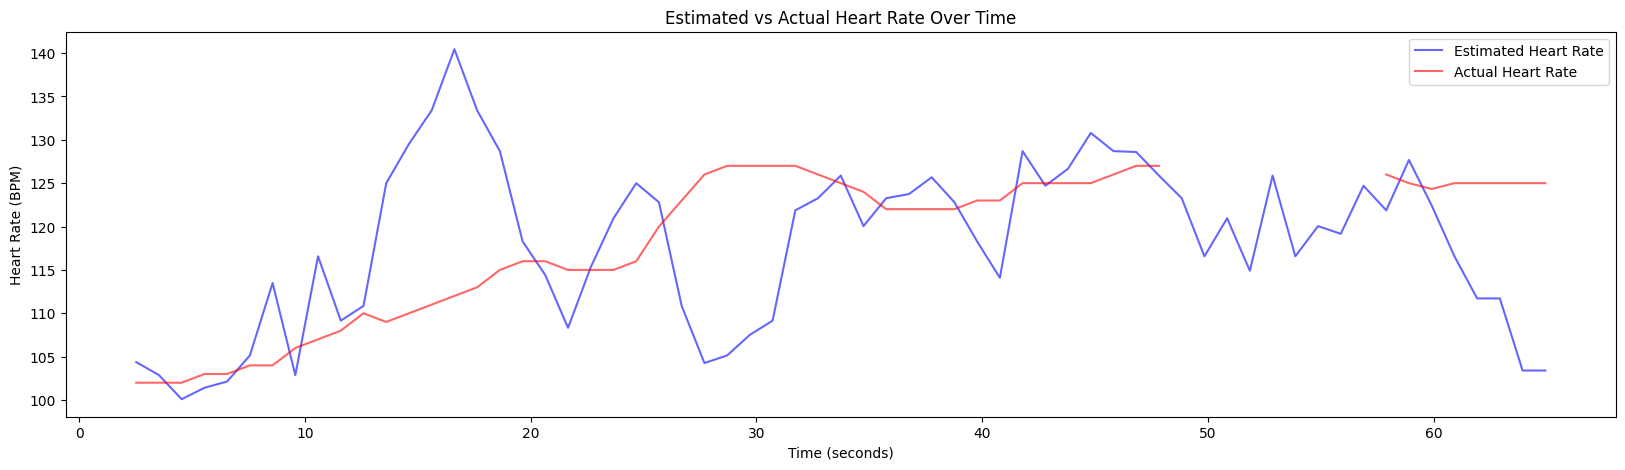

Average Estimated Heart Rate: 118.02
Average Actual Heart Rate: 118.15
MAE: 7.64
RMSE: 10.84
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject20.npz...


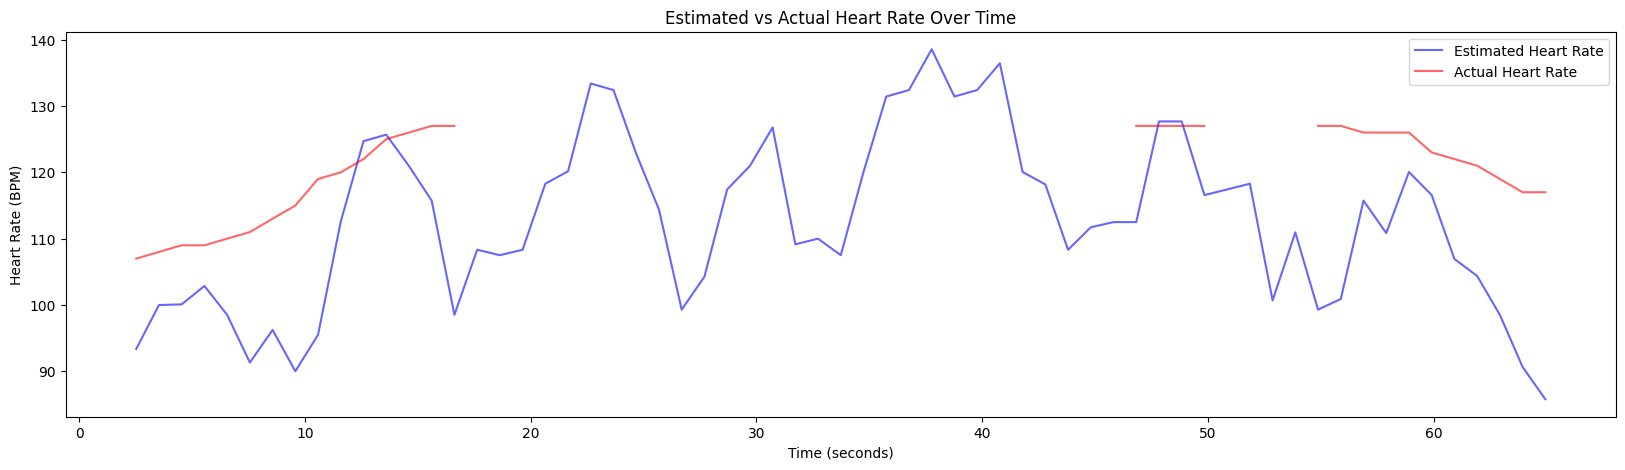

Average Estimated Heart Rate: 112.73
Average Actual Heart Rate: 120.23
MAE: 13.87
RMSE: 16.47
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject22.npz...


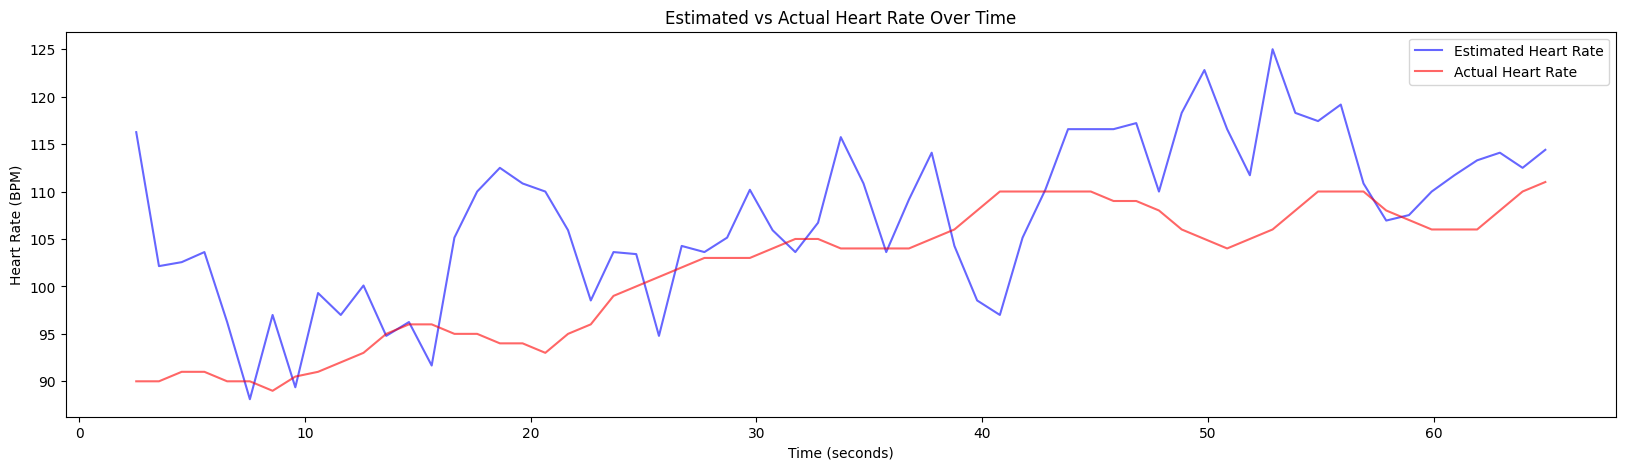

Average Estimated Heart Rate: 107.37
Average Actual Heart Rate: 101.72
MAE: 7.10
RMSE: 9.03
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject23.npz...


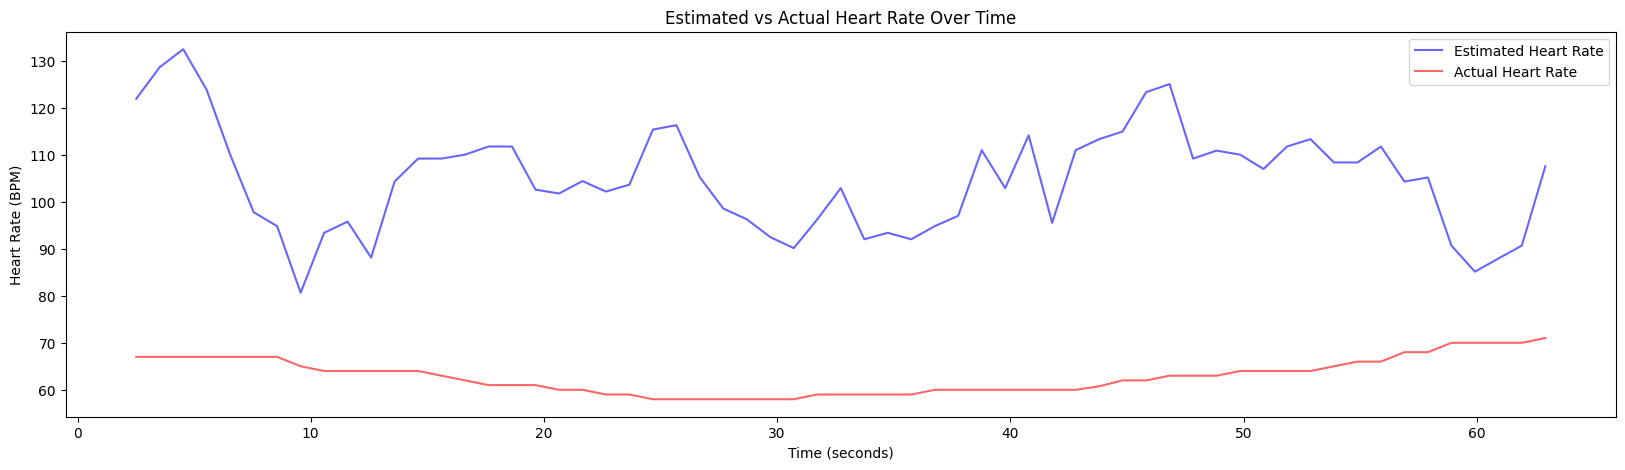

Average Estimated Heart Rate: 104.79
Average Actual Heart Rate: 62.86
MAE: 41.92
RMSE: 43.46
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject24.npz...


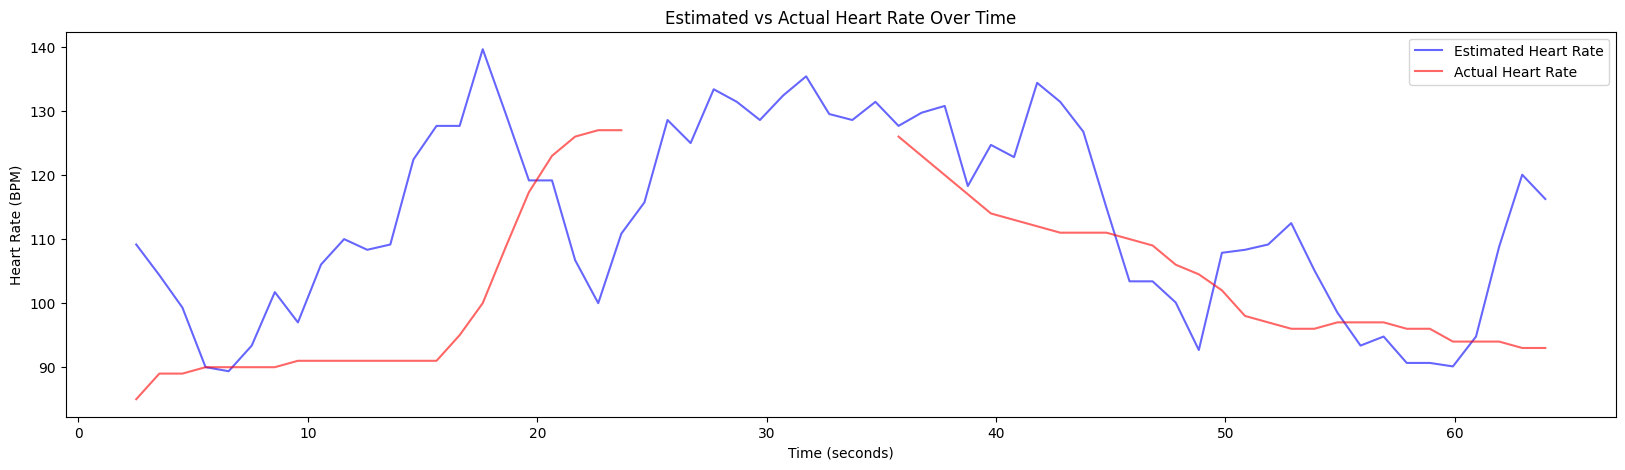

Average Estimated Heart Rate: 113.59
Average Actual Heart Rate: 102.19
MAE: 12.66
RMSE: 16.06
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject25.npz...


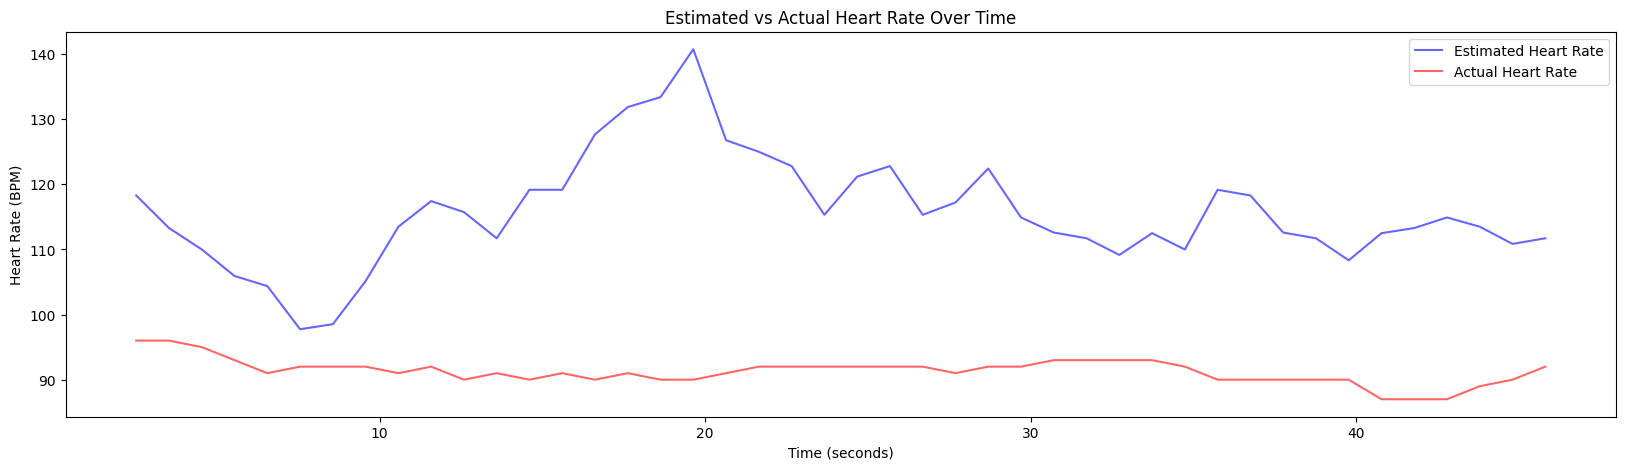

Average Estimated Heart Rate: 115.68
Average Actual Heart Rate: 91.30
MAE: 24.39
RMSE: 25.94
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject26.npz...


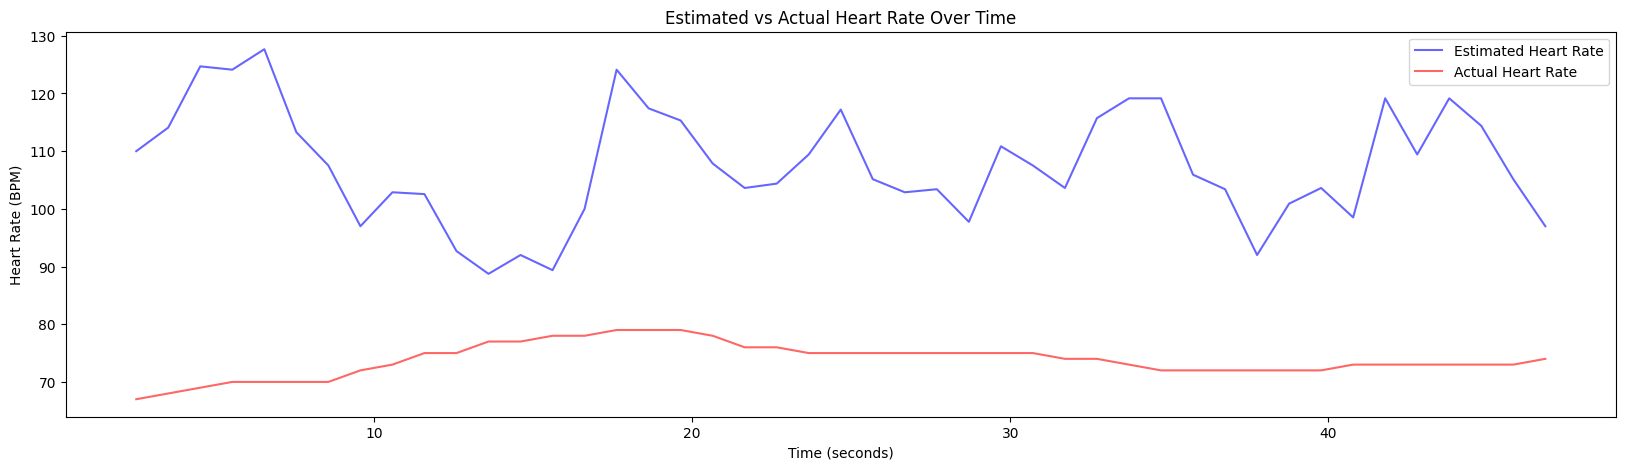

Average Estimated Heart Rate: 107.55
Average Actual Heart Rate: 73.80
MAE: 33.75
RMSE: 35.48
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject27.npz...


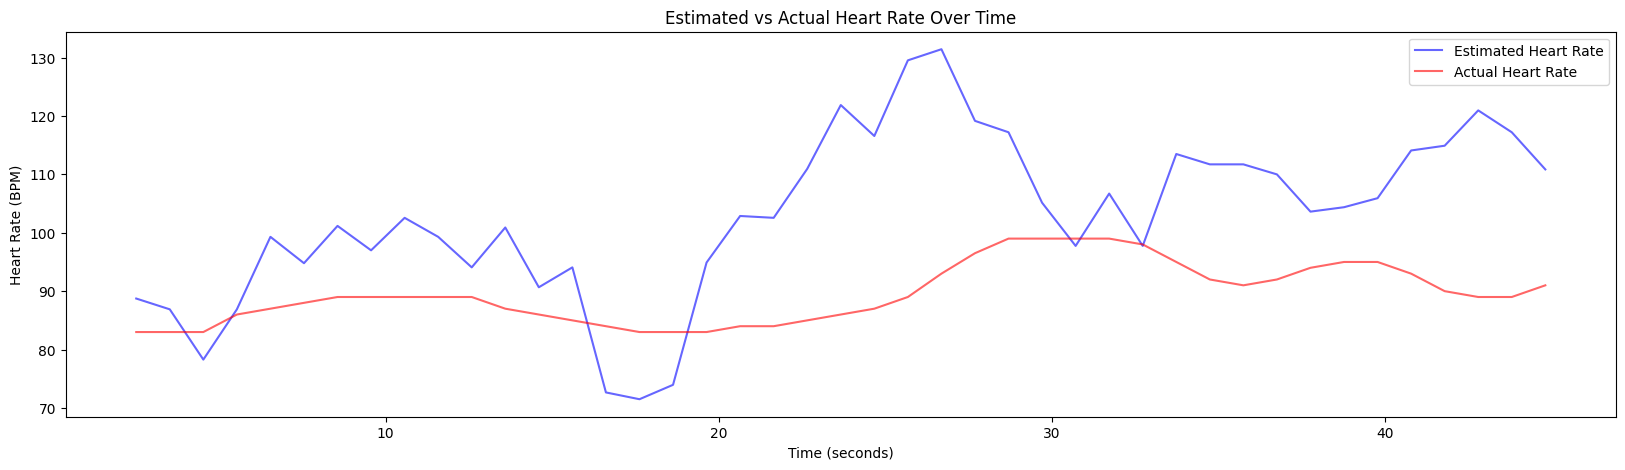

Average Estimated Heart Rate: 102.93
Average Actual Heart Rate: 89.55
MAE: 15.16
RMSE: 18.19
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject3.npz...


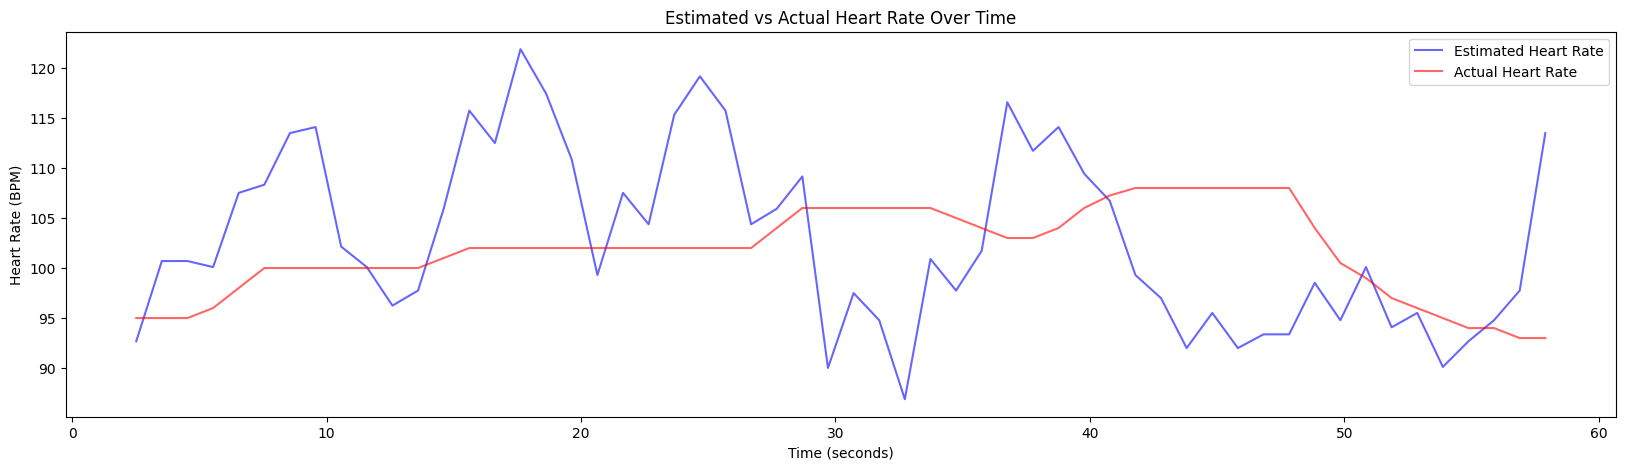

Average Estimated Heart Rate: 102.88
Average Actual Heart Rate: 101.75
MAE: 8.11
RMSE: 9.93
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject30.npz...


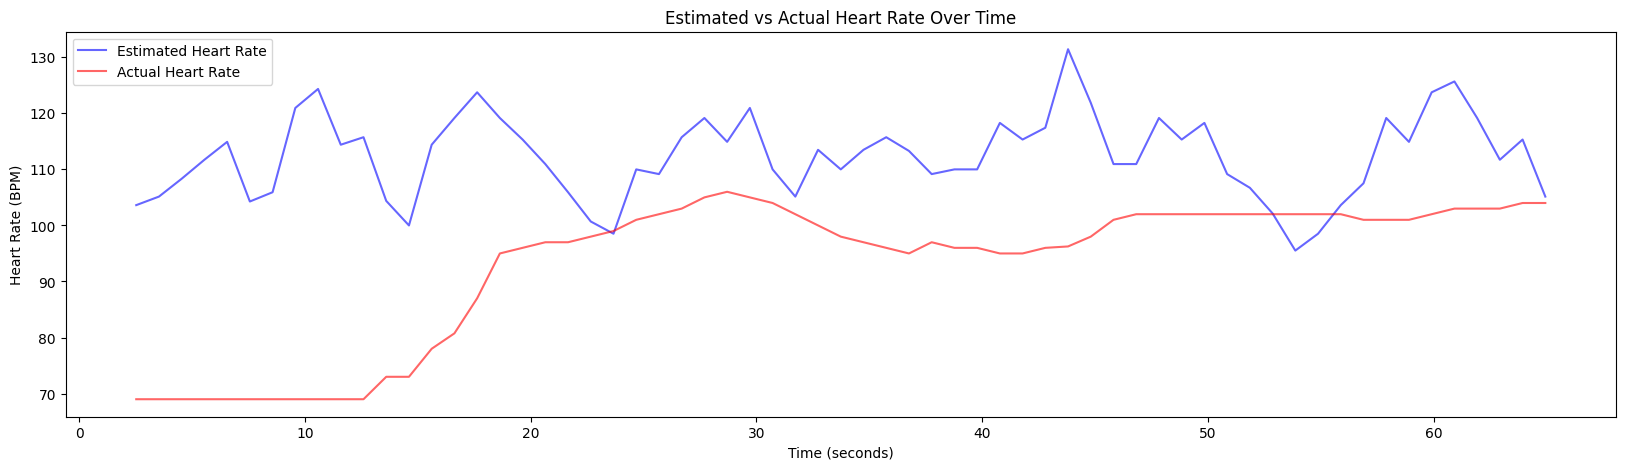

Average Estimated Heart Rate: 112.36
Average Actual Heart Rate: 93.00
MAE: 19.69
RMSE: 24.14
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject31.npz...


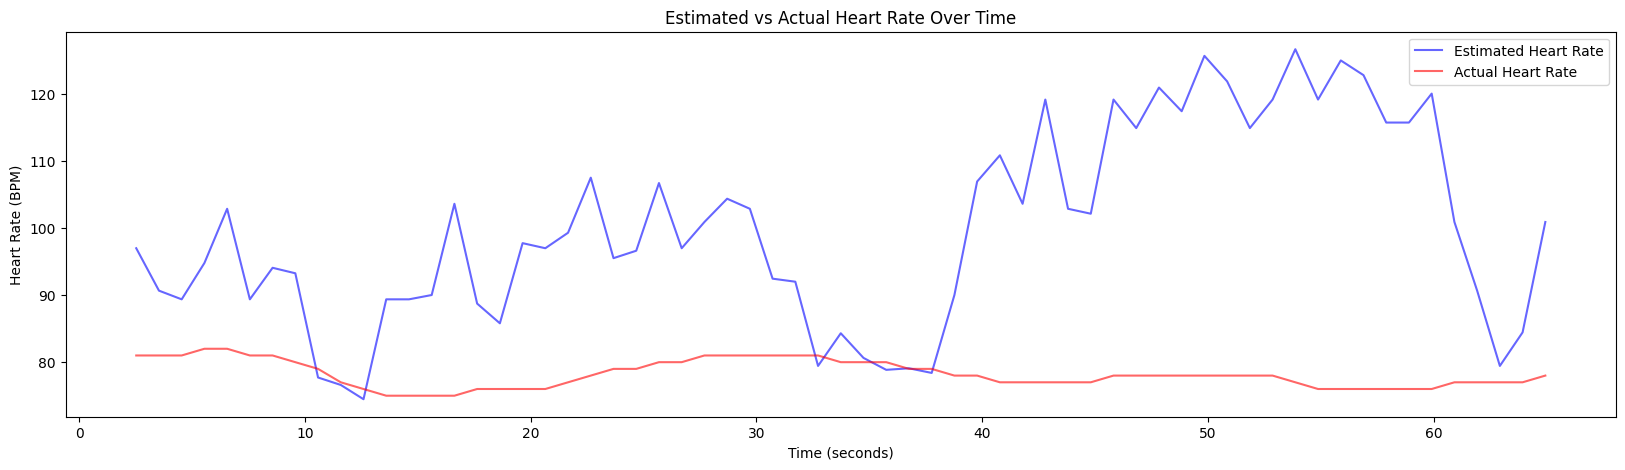

Average Estimated Heart Rate: 99.82
Average Actual Heart Rate: 78.19
MAE: 21.84
RMSE: 26.34
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject32.npz...


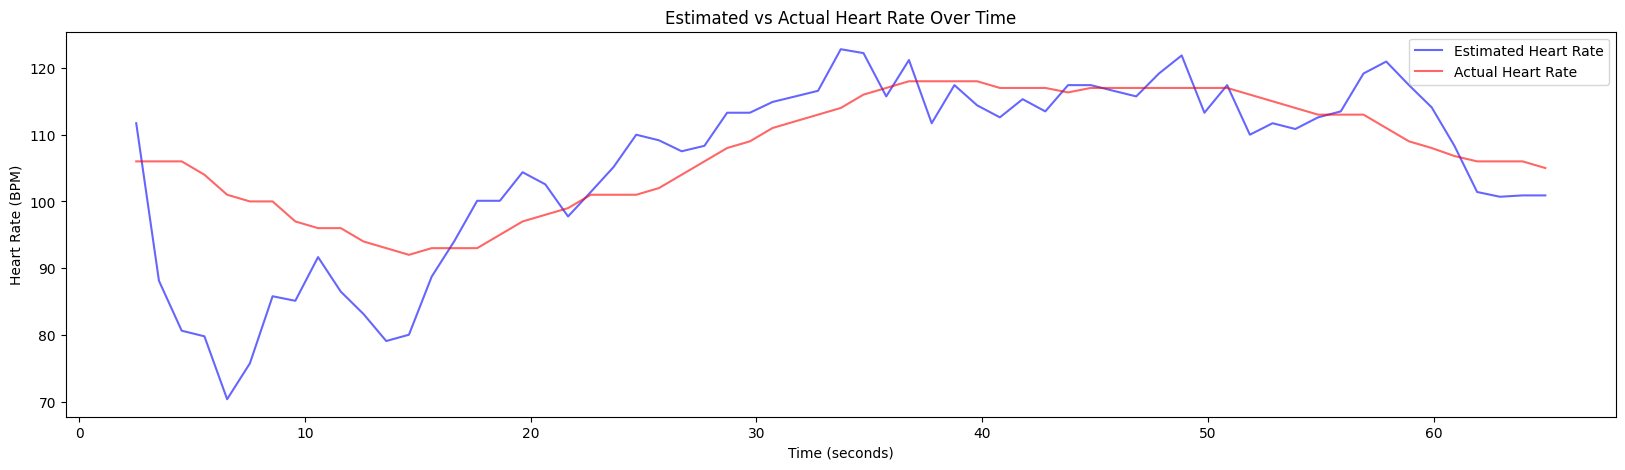

Average Estimated Heart Rate: 105.54
Average Actual Heart Rate: 107.53
MAE: 6.37
RMSE: 9.00
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject33.npz...


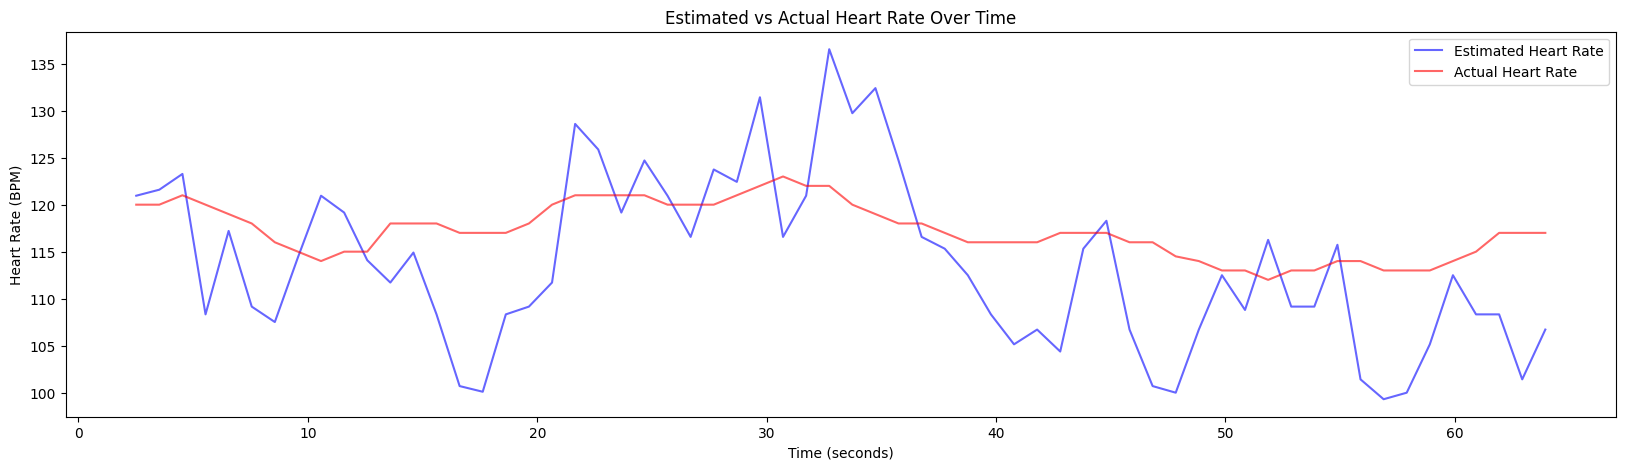

Average Estimated Heart Rate: 113.67
Average Actual Heart Rate: 117.23
MAE: 6.77
RMSE: 8.24
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject34.npz...


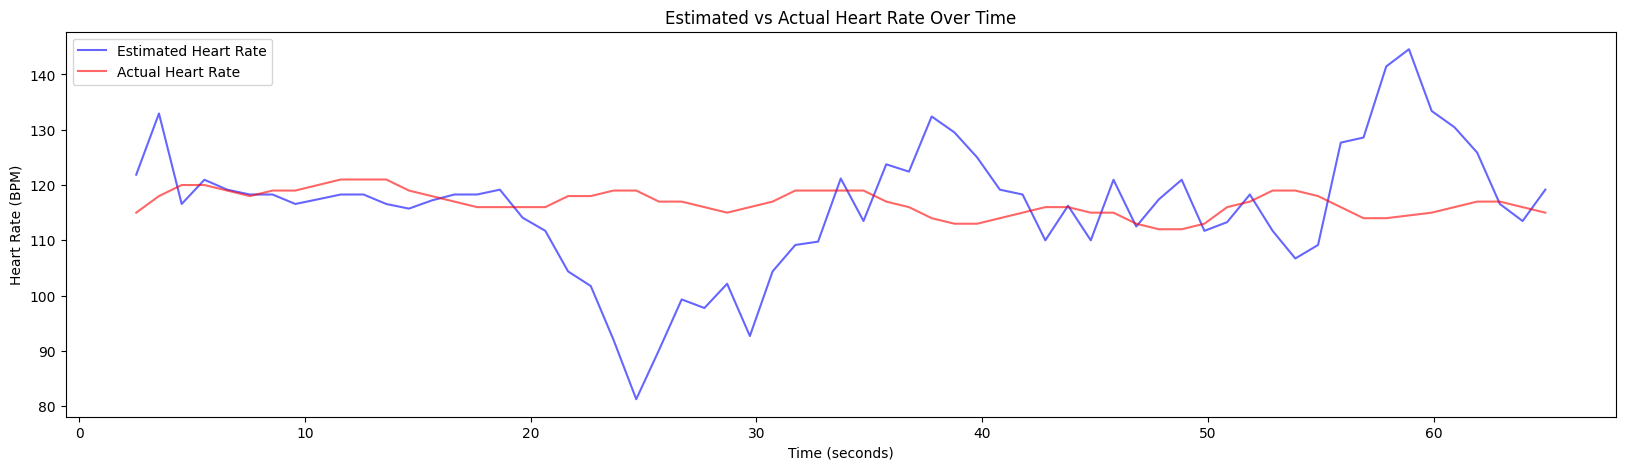

Average Estimated Heart Rate: 115.87
Average Actual Heart Rate: 116.74
MAE: 8.88
RMSE: 12.26
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject35.npz...


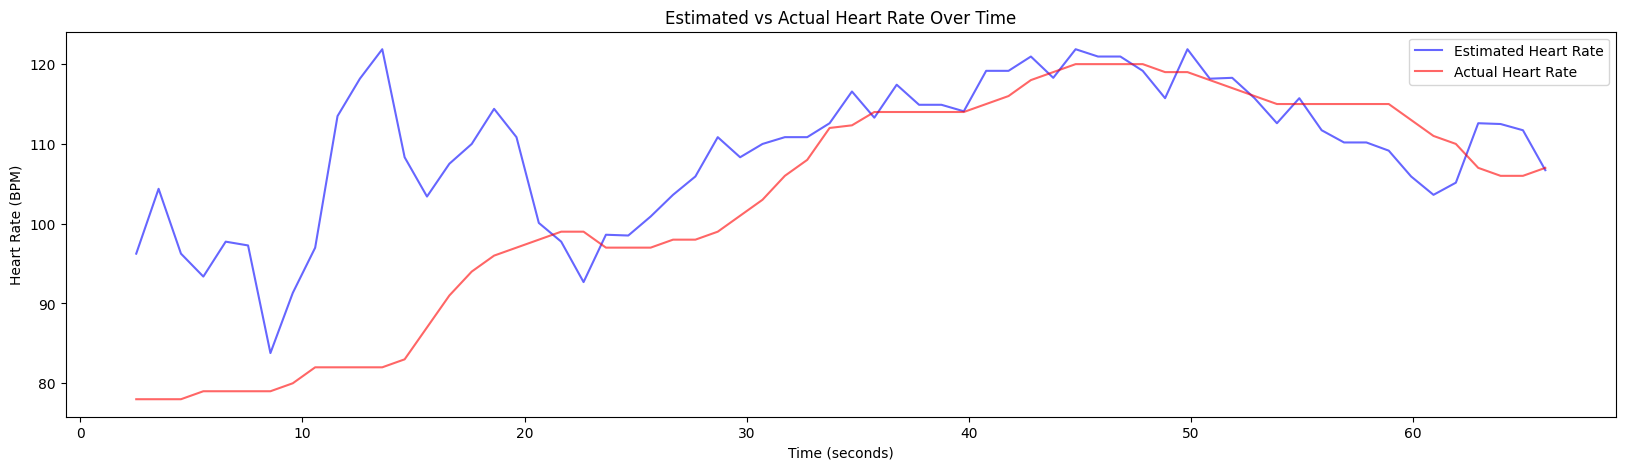

Average Estimated Heart Rate: 109.32
Average Actual Heart Rate: 102.93
MAE: 8.08
RMSE: 12.09
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject36.npz...


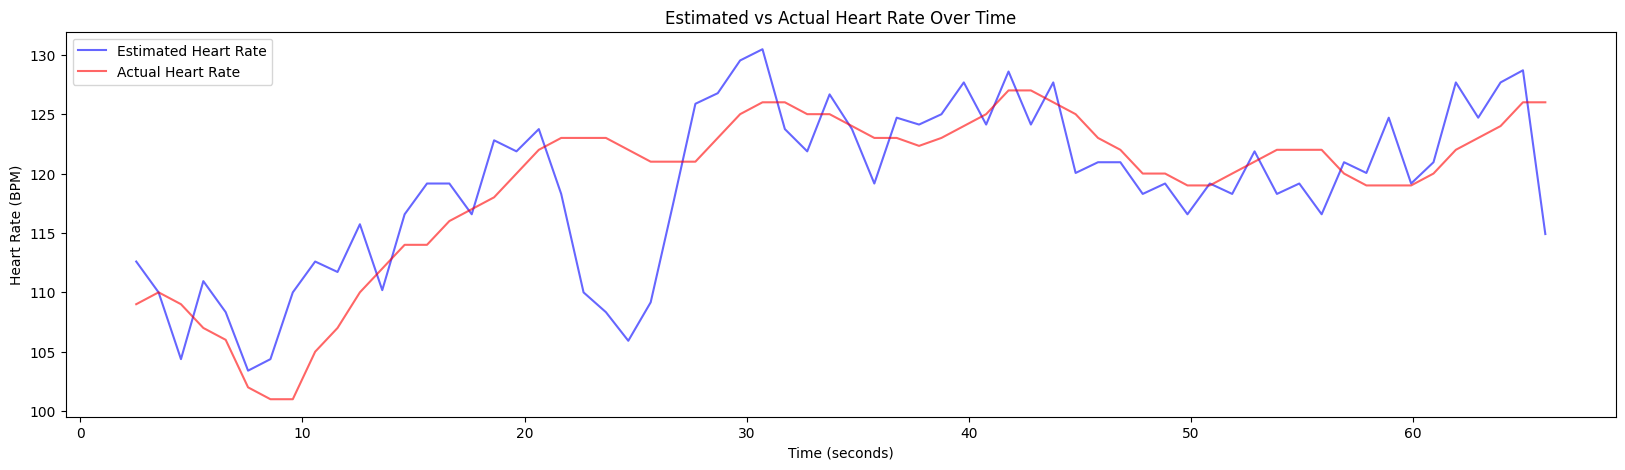

Average Estimated Heart Rate: 119.00
Average Actual Heart Rate: 119.08
MAE: 3.72
RMSE: 5.02
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject37.npz...


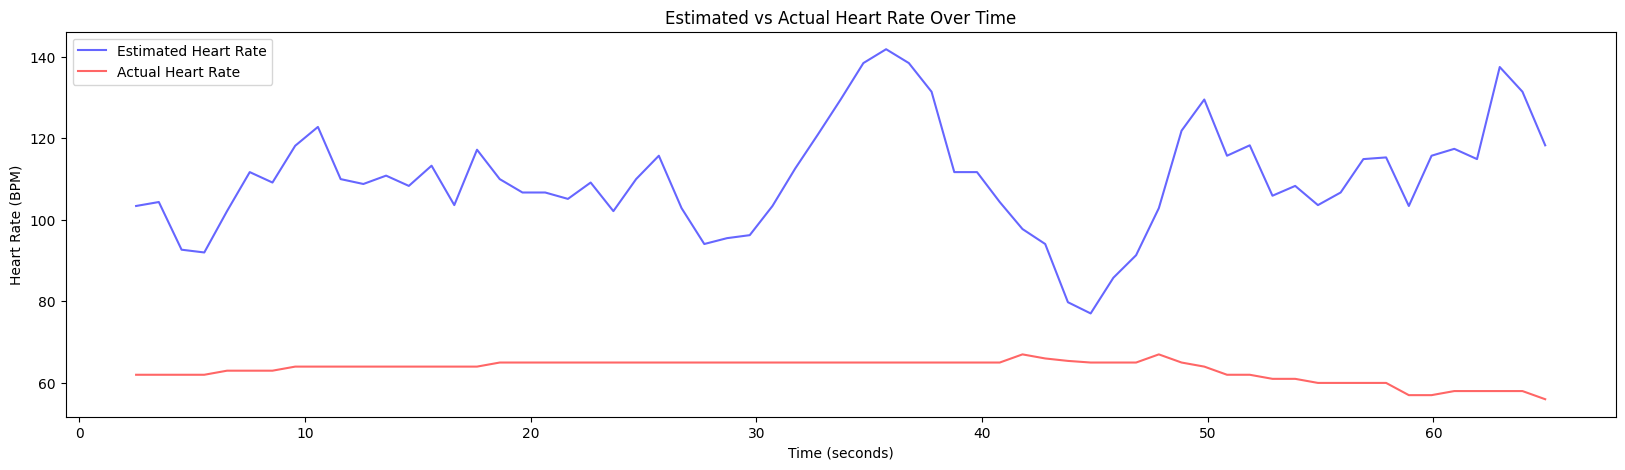

Average Estimated Heart Rate: 110.08
Average Actual Heart Rate: 63.26
MAE: 46.82
RMSE: 48.90
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject38.npz...


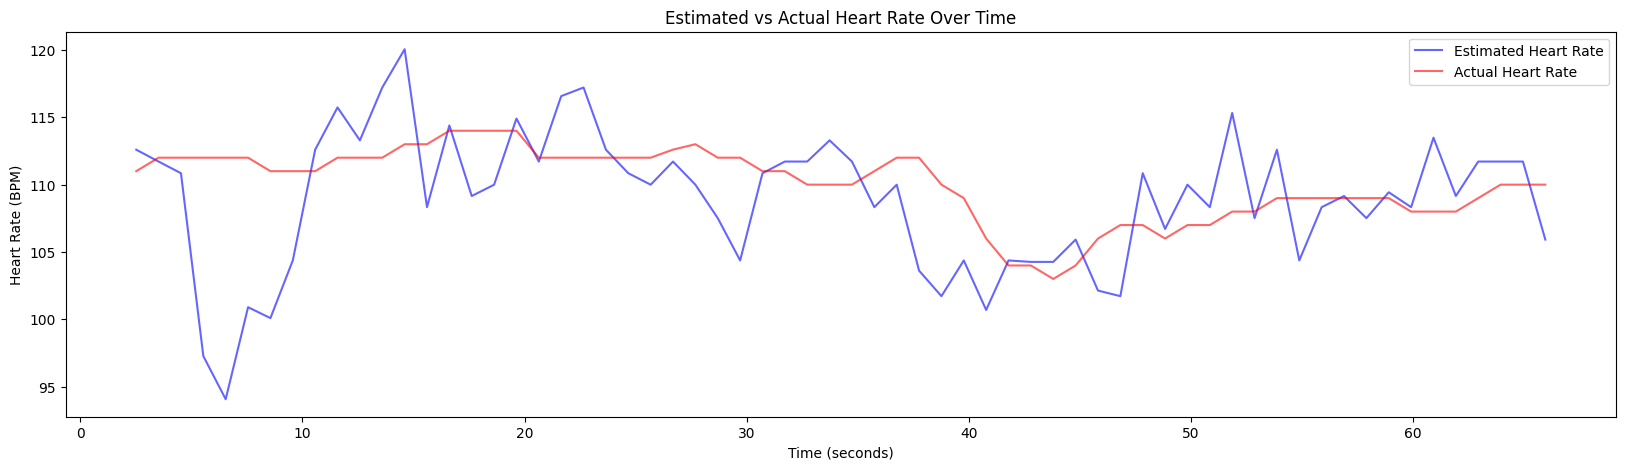

Average Estimated Heart Rate: 108.95
Average Actual Heart Rate: 110.06
MAE: 3.51
RMSE: 4.95
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject39.npz...


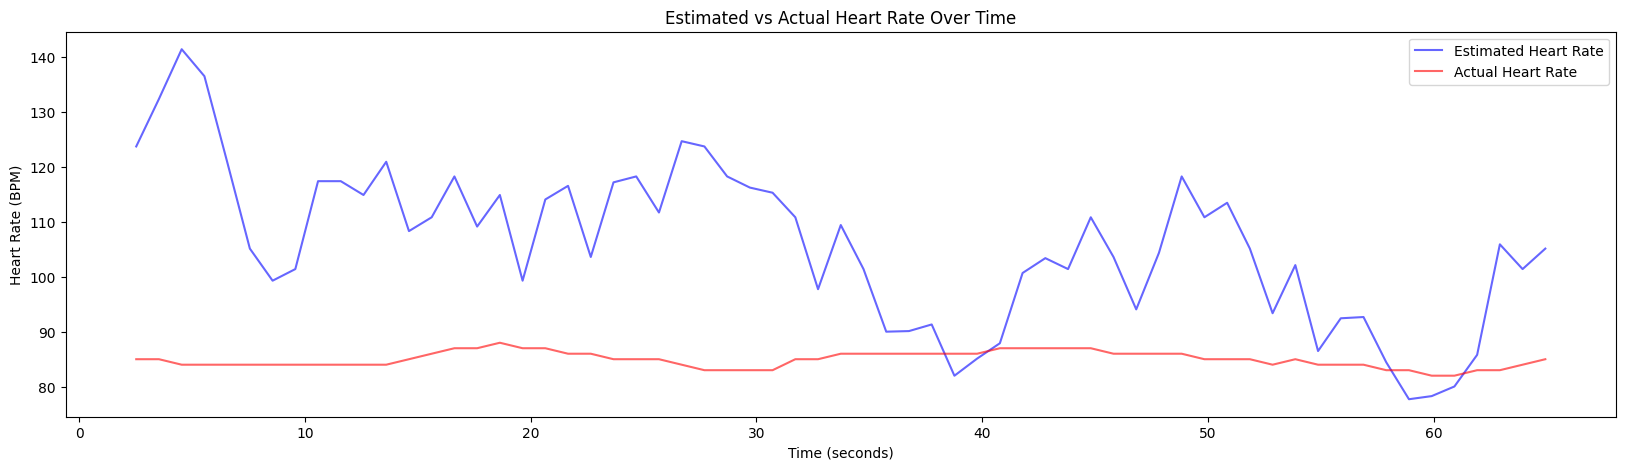

Average Estimated Heart Rate: 105.88
Average Actual Heart Rate: 84.95
MAE: 21.43
RMSE: 25.25
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject4.npz...


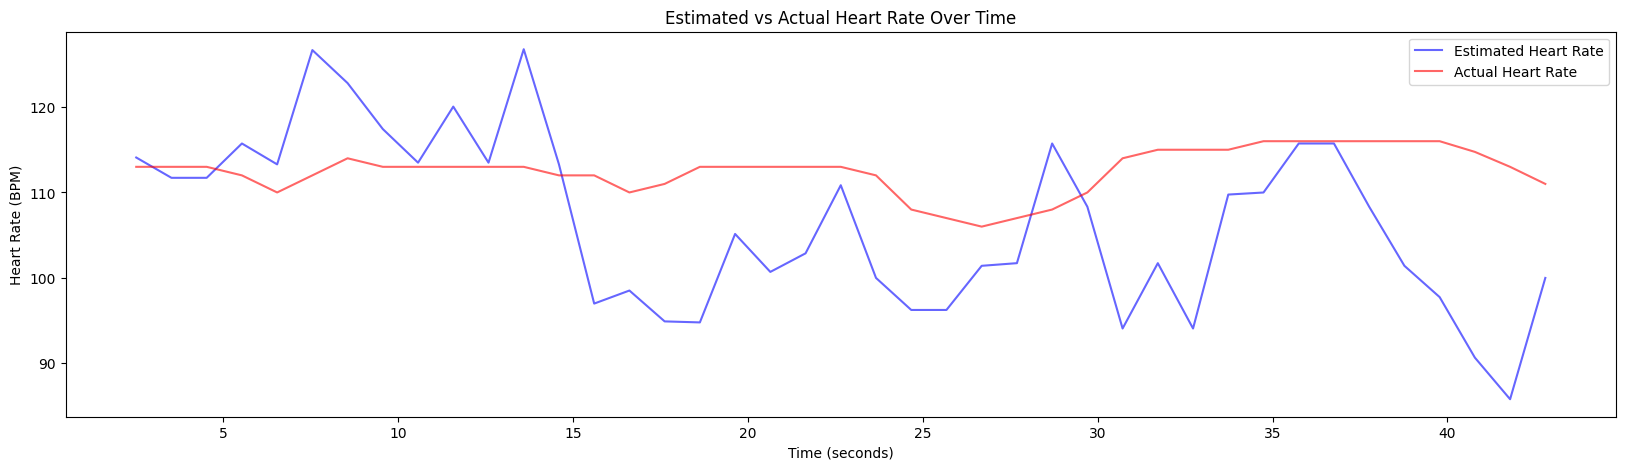

Average Estimated Heart Rate: 106.59
Average Actual Heart Rate: 112.53
MAE: 9.20
RMSE: 11.56
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject40.npz...


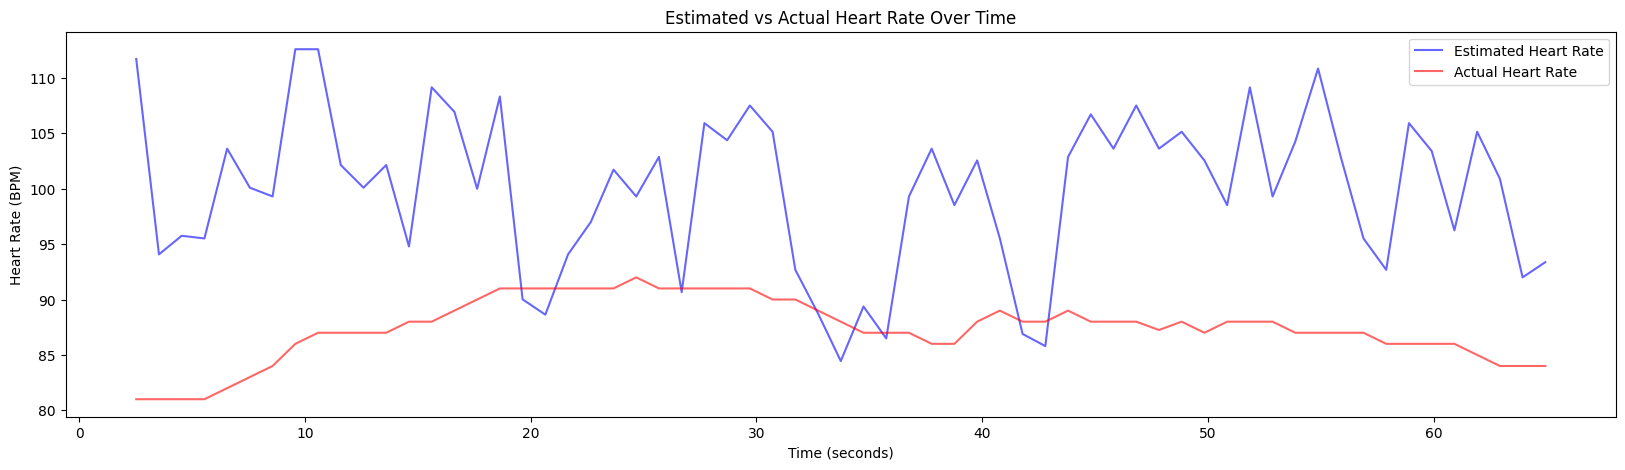

Average Estimated Heart Rate: 99.88
Average Actual Heart Rate: 87.40
MAE: 12.83
RMSE: 14.61
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject41.npz...


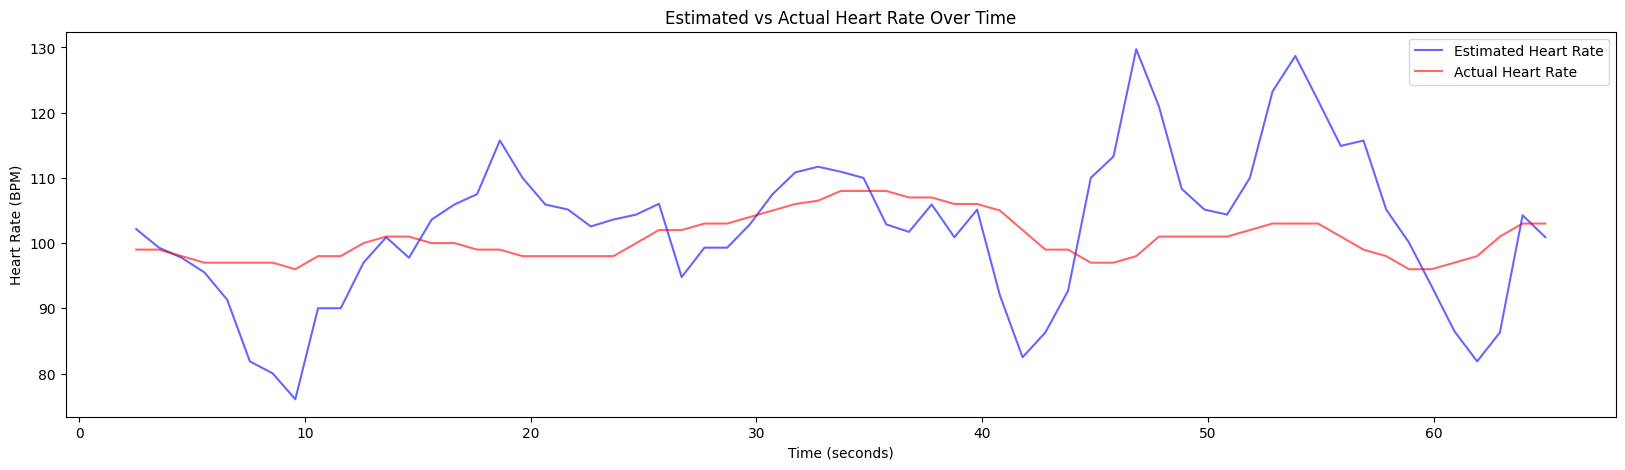

Average Estimated Heart Rate: 102.41
Average Actual Heart Rate: 100.82
MAE: 8.34
RMSE: 10.83
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject42.npz...


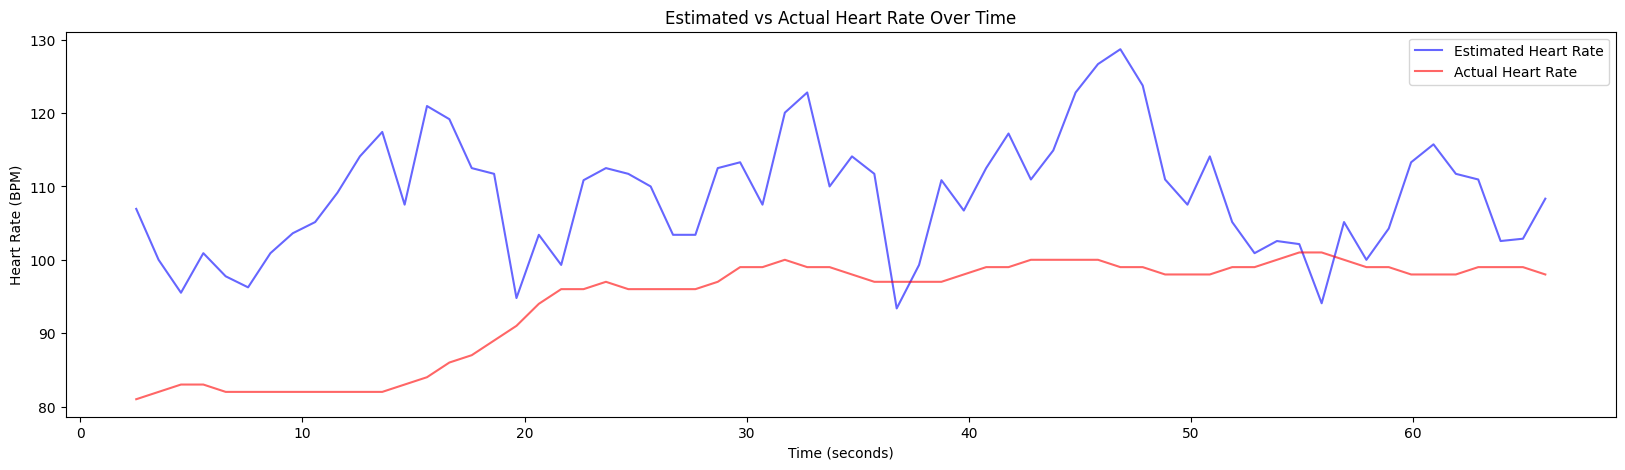

Average Estimated Heart Rate: 108.76
Average Actual Heart Rate: 94.16
MAE: 14.93
RMSE: 17.36
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject43.npz...


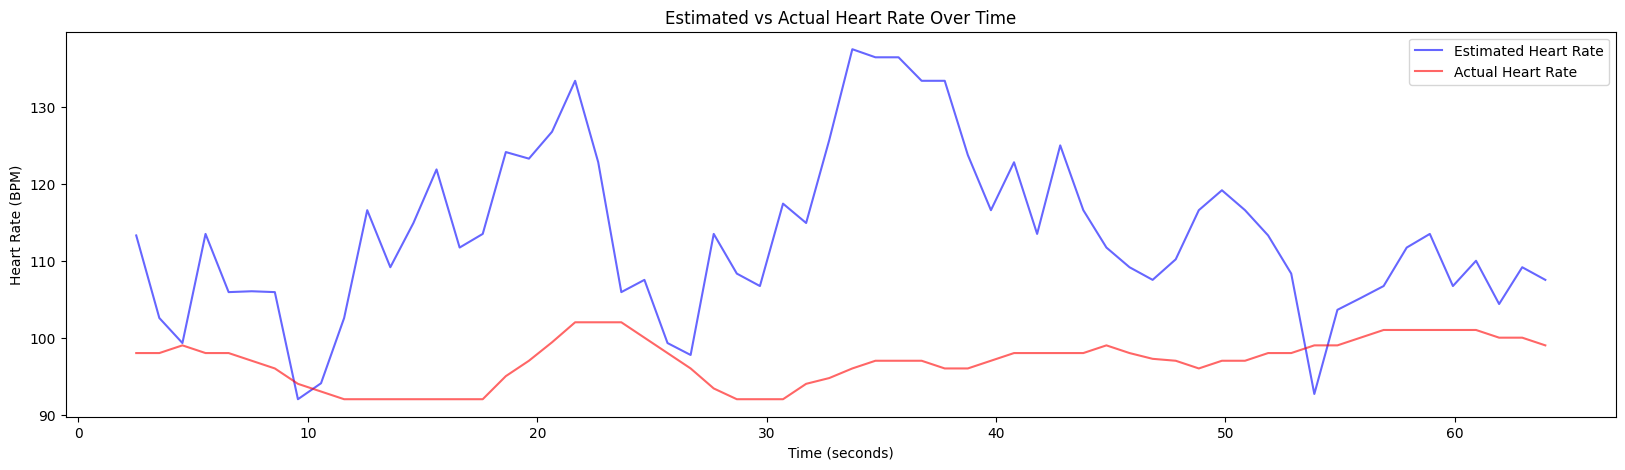

Average Estimated Heart Rate: 113.37
Average Actual Heart Rate: 96.96
MAE: 16.68
RMSE: 19.78
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject44.npz...


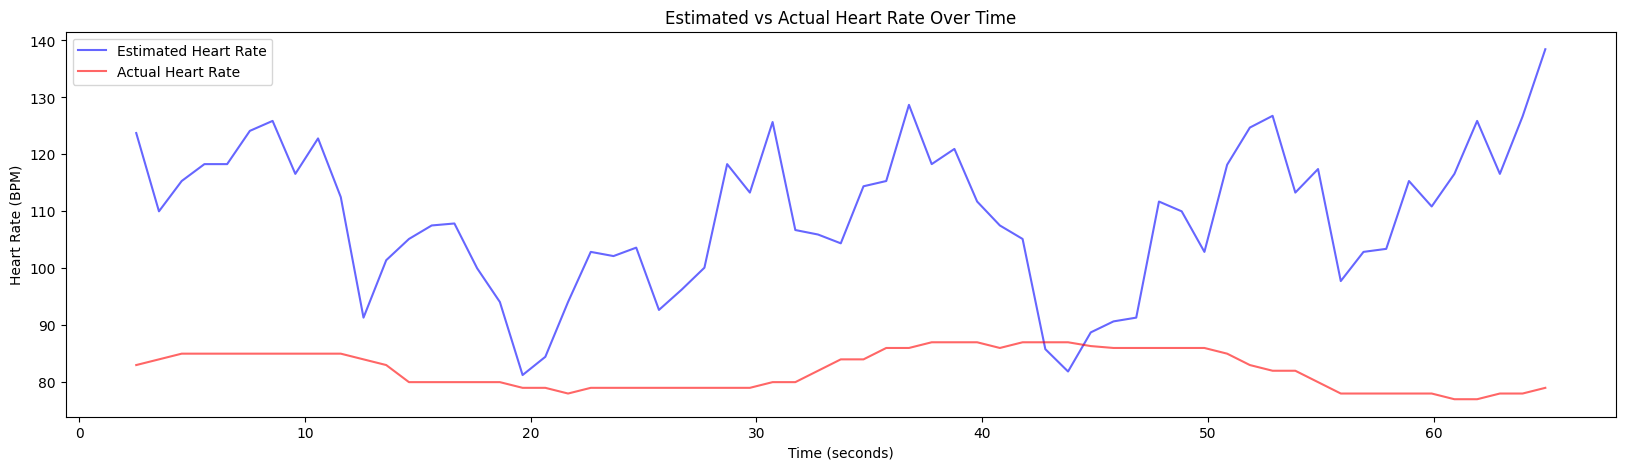

Average Estimated Heart Rate: 108.99
Average Actual Heart Rate: 82.21
MAE: 26.98
RMSE: 29.79
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject45.npz...


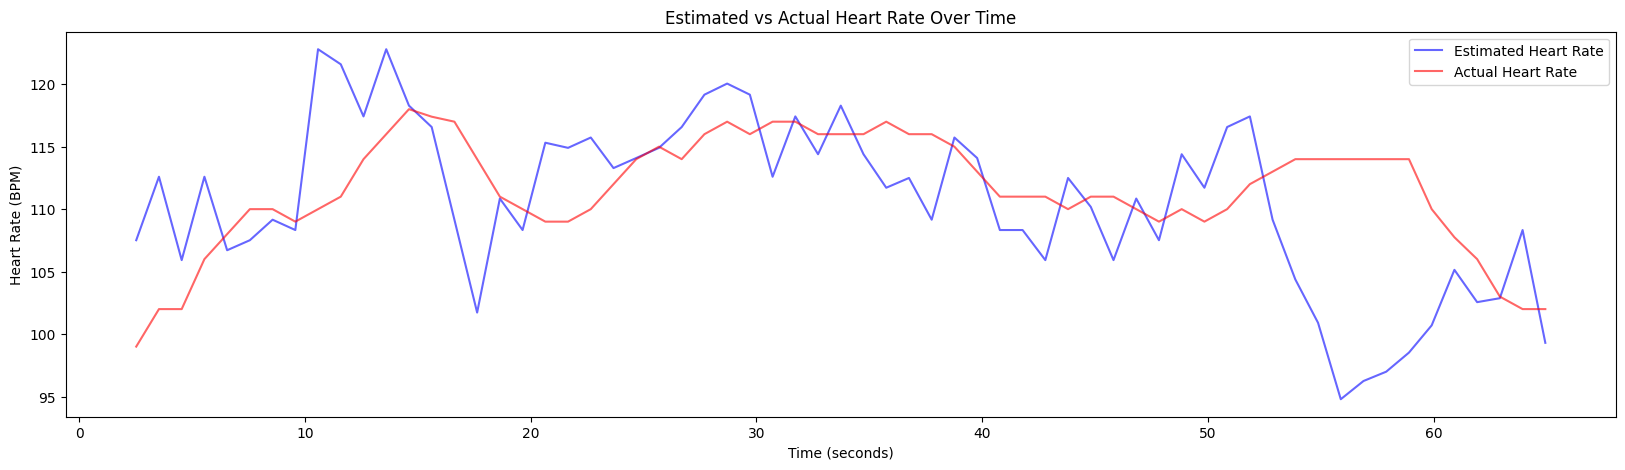

Average Estimated Heart Rate: 110.68
Average Actual Heart Rate: 111.56
MAE: 4.94
RMSE: 6.77
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject46.npz...


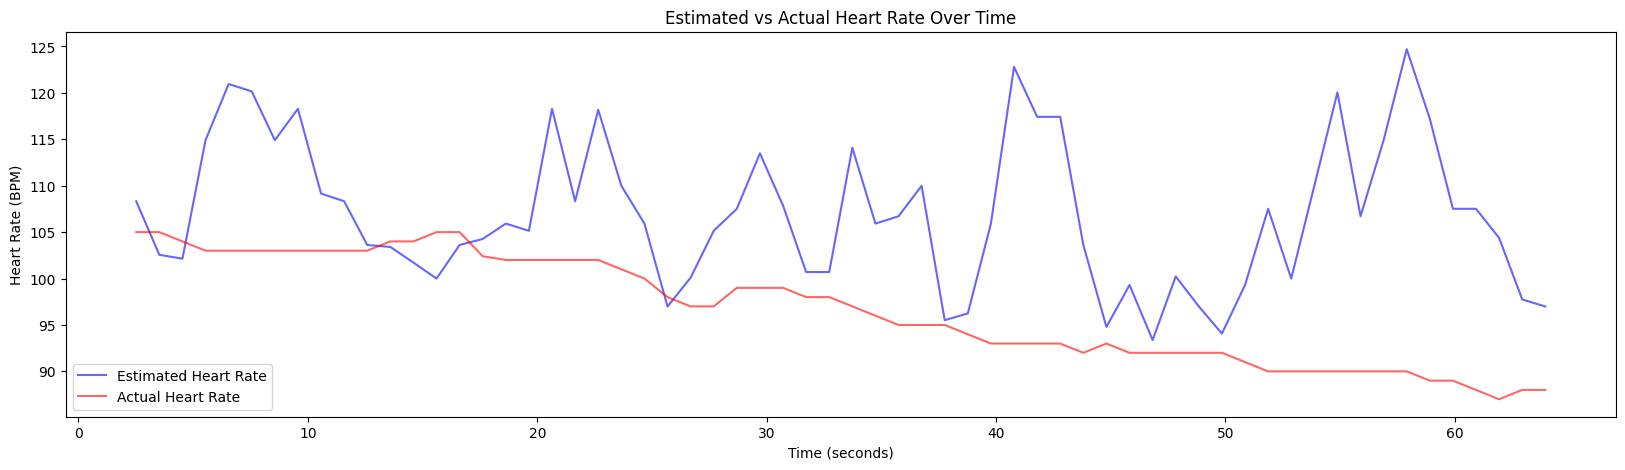

Average Estimated Heart Rate: 106.93
Average Actual Heart Rate: 96.67
MAE: 10.73
RMSE: 13.67
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject47.npz...


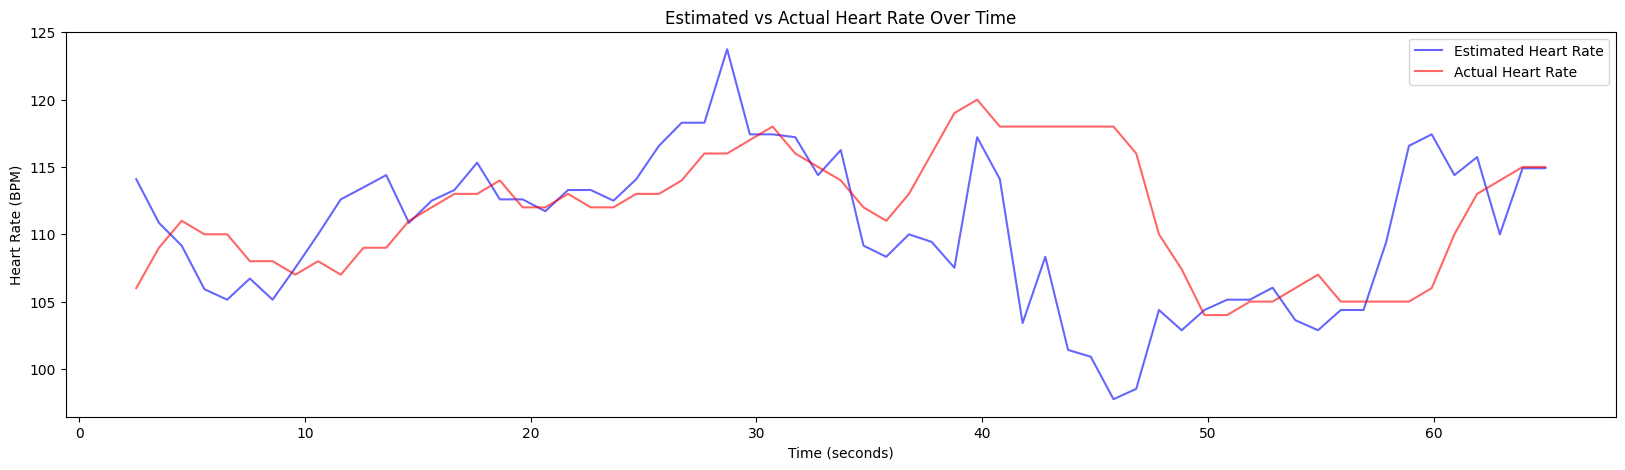

Average Estimated Heart Rate: 110.46
Average Actual Heart Rate: 111.66
MAE: 4.17
RMSE: 6.35
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject48.npz...


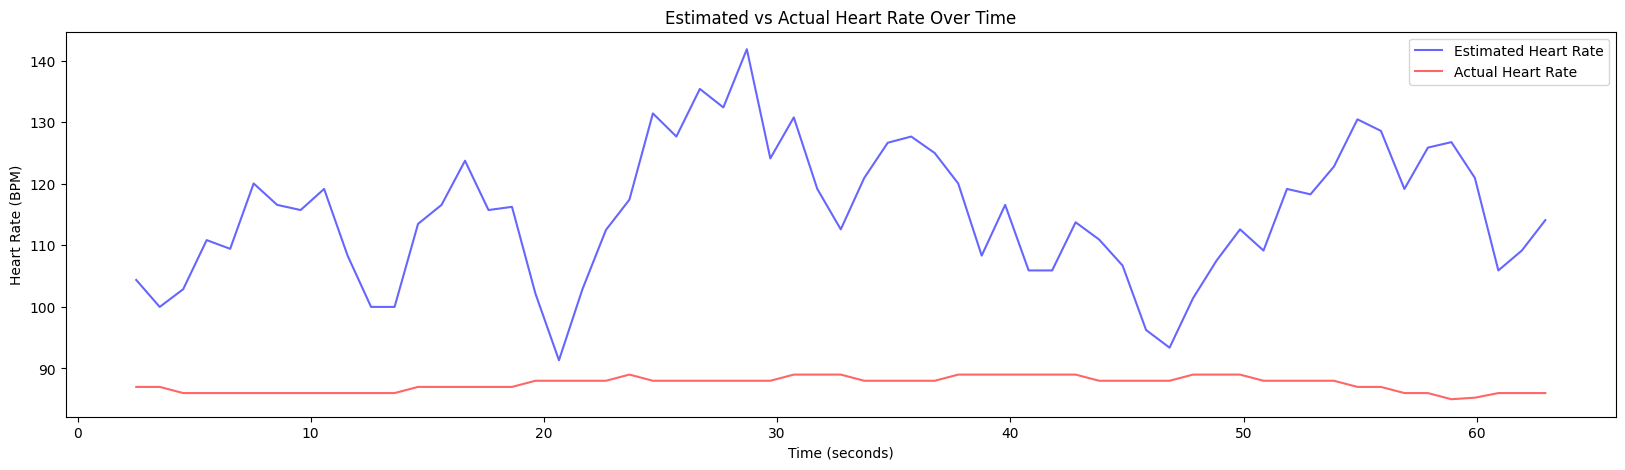

Average Estimated Heart Rate: 115.16
Average Actual Heart Rate: 87.48
MAE: 27.68
RMSE: 29.72
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject49.npz...


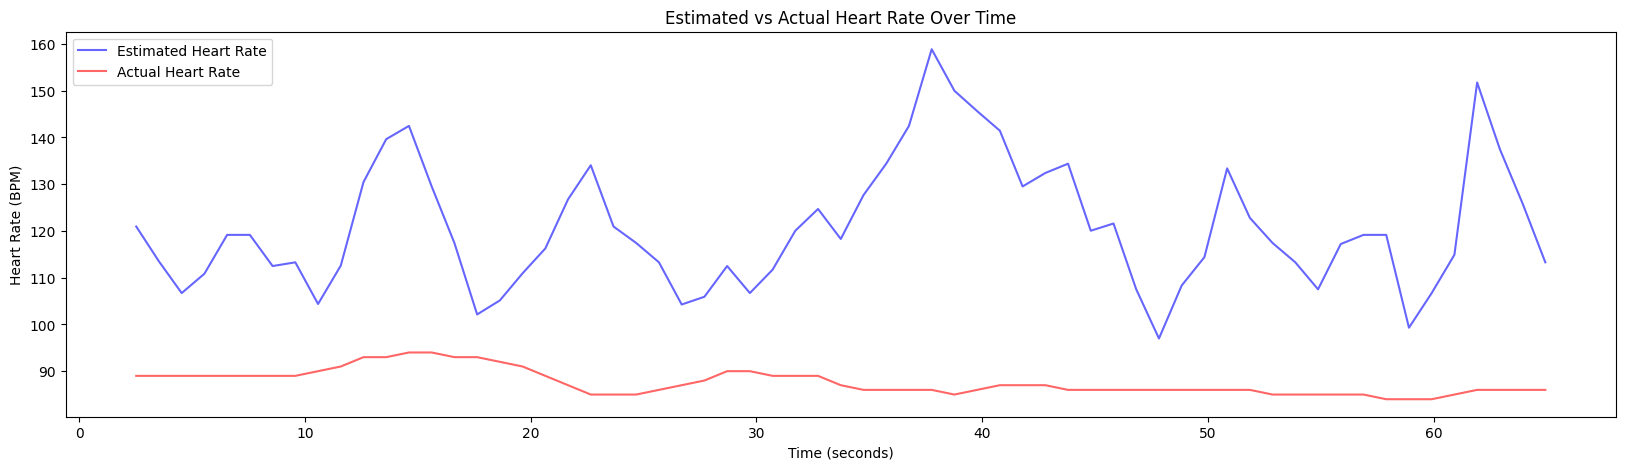

Average Estimated Heart Rate: 120.77
Average Actual Heart Rate: 87.59
MAE: 33.19
RMSE: 36.00
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject5.npz...


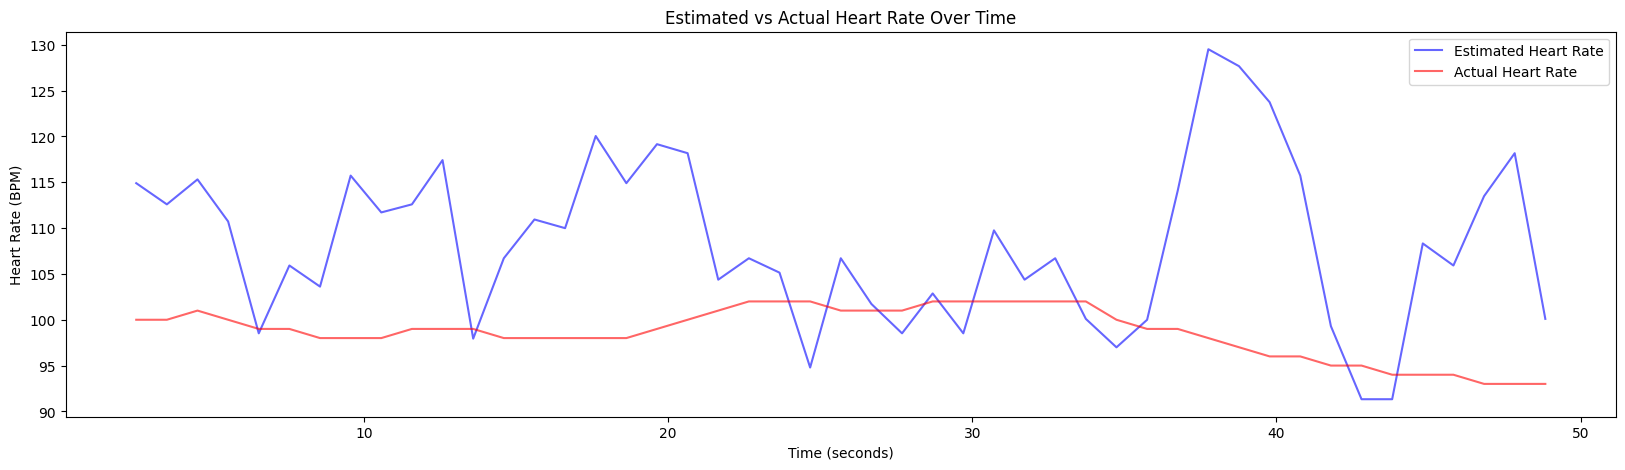

Average Estimated Heart Rate: 108.36
Average Actual Heart Rate: 98.66
MAE: 10.81
RMSE: 13.66
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject8.npz...


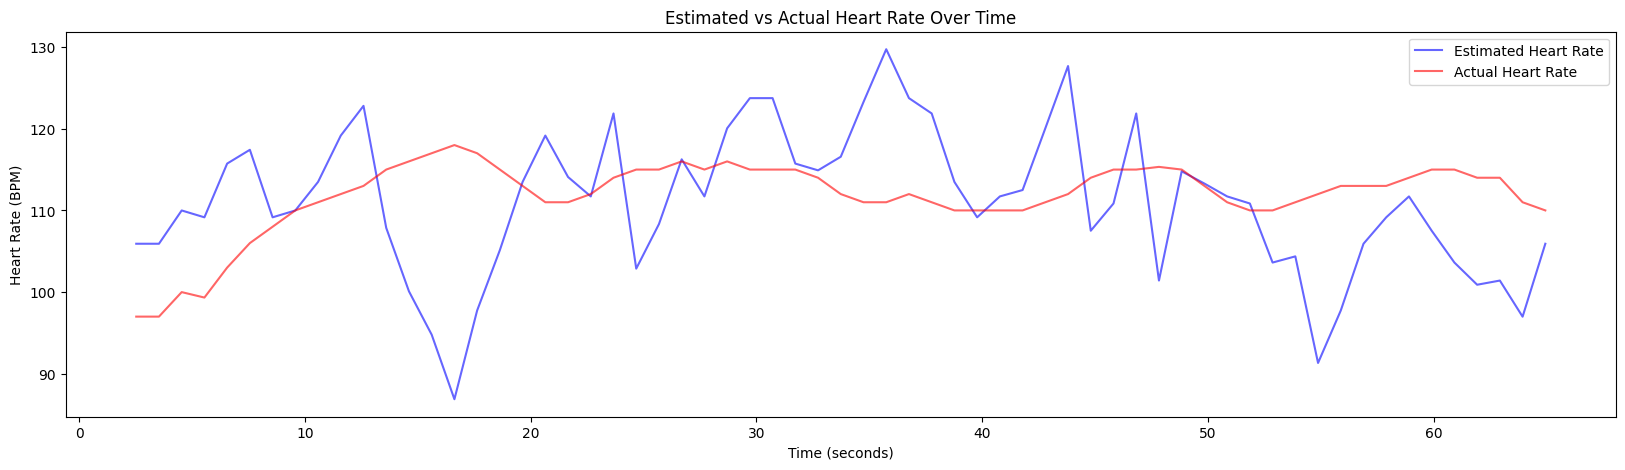

Average Estimated Heart Rate: 110.97
Average Actual Heart Rate: 111.82
MAE: 7.98
RMSE: 10.17
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject9.npz...


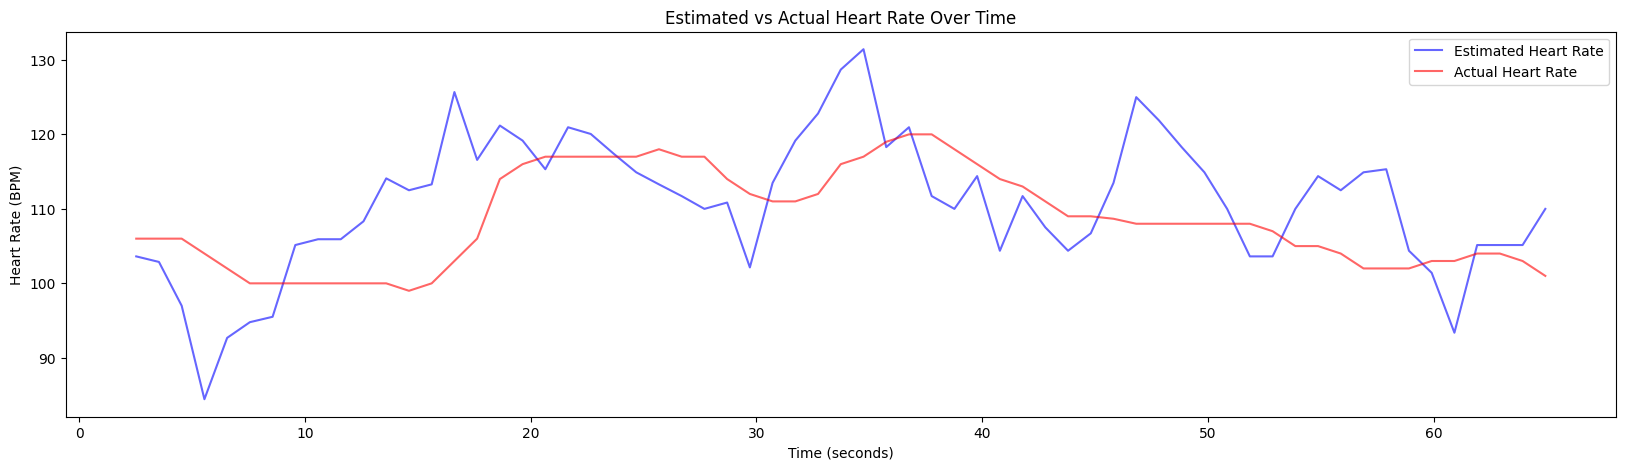

Average Estimated Heart Rate: 110.85
Average Actual Heart Rate: 108.61
MAE: 6.86
RMSE: 8.45
---------------------------------------------------------------------------


In [35]:
directory = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/'

rmse_list, mae_list, subject_list = process_npz_files(directory)

In [36]:
# 모든 파일의 MAE 출력
print("MSE List:", mae_list)
print("Average MSE across all files:", np.mean(mae_list))
print("---------------------------------------------------------------------------")

MSE List: [6.463940147015004, 9.023751551874895, 12.821440066051899, 33.92275247962176, 9.984758227489458, 27.941282497088686, 8.074734323494837, 8.082658195010119, 30.672150872974182, 7.641086623729024, 13.873659799492282, 7.101521381861402, 41.92453801202462, 12.656697191533786, 24.388567382981726, 33.75130392546111, 15.155062479612791, 8.110204879967126, 19.69182166363134, 21.84095491027987, 6.369360434029451, 6.771024409281182, 8.876960810104254, 8.080401357984375, 3.7207524970044092, 46.81649494793738, 3.5073460268450884, 21.42832903130911, 9.204341995963894, 12.834369297375384, 8.344966370087109, 14.93442327387134, 16.676837330989237, 26.976517220878566, 4.944704225688148, 10.730470764524439, 4.171564550200141, 27.68184384331855, 33.185470093294974, 10.806366758902628, 7.984442024060659, 6.86161740758487]
Average MSE across all files: 15.572178363867405
---------------------------------------------------------------------------


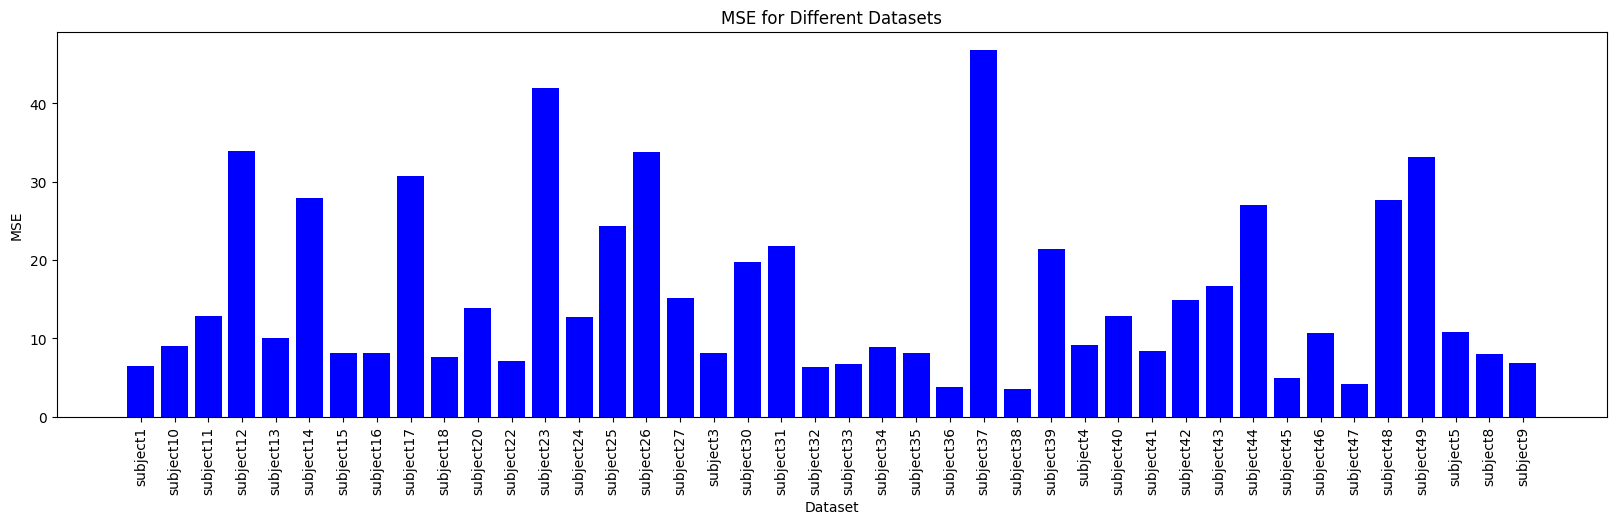

In [37]:
plt.figure(figsize=(20, 5))
plt.bar(subject_list, mae_list, color='blue')
plt.xlabel('Dataset')
plt.ylabel('MSE')
plt.title('MSE for Different Datasets')
plt.xticks(rotation='vertical')
plt.show()